<div style="background-color:red; color:white; size:20px;">word2vec+HD+multi</div>

In [4]:
#importing the libraries, stopwords, etc.
import nltk
nltk.download('stopwords')
#from utils import process_tweet, build_freqs
# importing the libraries 
import re #for regular expression operations
import string #for string operations
from nltk.corpus import stopwords #for importing stopwords
from nltk.stem import PorterStemmer #for importing stemmer 
from nltk.tokenize import TweetTokenizer #for importing tweet tokenizer
from sklearn.feature_extraction.text import CountVectorizer
from itertools import islice #iter in dictionary
from keras.preprocessing import image #for plotting the wordcloud
import seaborn as sns
import gc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import log_loss,confusion_matrix,classification_report,roc_curve,auc
from nltk.tokenize import word_tokenize
from scipy import sparse
from nltk.corpus import twitter_samples

from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

import transformers
from transformers import XLNetTokenizer, XLNetModel, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pickle
import sys
import time
from copy import deepcopy

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from collections import defaultdict
from textwrap import wrap
from pylab import rcParams

from torch import nn, optim
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset,RandomSampler,SequentialSampler
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from nltk.corpus import twitter_samples


def process_tweet(review):
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    review_tokens = review.split()
    cleaned_review = []
    for word in review_tokens:
        if (word not in stopwords_english and  # remove stopwords
                word not in string.punctuation):  # remove punctuation
            stem_word = stemmer.stem(word)  # stemming word
            cleaned_review.append(stem_word)
    return cleaned_review

def max_match(class_hvs, enc_hv, class_norms):
        max_score = -np.inf
        max_index = -1
        for i in range(len(class_hvs)):
        #print("***",len(class_hvs[i]), len(enc_hv))
            score = np.matmul(class_hvs[i], enc_hv) / class_norms[i]
            if score > max_score:
                max_score = score
                max_index = i
        return max_index
    
#importing the training and test data from NLTK's twitter_samples
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')

test_pos = all_positive_tweets[4000:]
train_pos = all_positive_tweets[:4000]
test_neg = all_negative_tweets[4000:]
train_neg = all_negative_tweets[:4000]

train_x = train_pos + train_neg 
test_x = test_pos + test_neg
# combinung positive and negative labels
train_y = np.append(np.ones((len(train_pos), 1)), np.zeros((len(train_neg), 1)), axis=0)
test_y = np.append(np.ones((len(test_pos), 1)), np.zeros((len(test_neg), 1)), axis=0)

cleaned_review = []
for sentence in train_x:
    cleaned_review.append(process_tweet(sentence))
    
cleaned_test = []
for sentence in test_x:
    cleaned_test.append(process_tweet(sentence))
    
sentences = cleaned_review

unique_words = {}
for i in range(len(cleaned_review)):
    for j in range(len(cleaned_review[i])):
        word = cleaned_review[i][j]
        if word not in unique_words:
            unique_words[word] = 1
        else:
            unique_words[word] += 1 

# Set values for various parameters
num_features = 535    # Word vector dimensionality                      
min_word_count = 15   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 20          # Context window size                                                                                    
downsampling = 1e-5   # Downsample setting for frequent words

# Initialize and train the model (this will take some time)
from gensim.models import word2vec
print ("Training model...")
w2v_model = word2vec.Word2Vec(sentences, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)

# If you don't plan to train the model any further, calling 
# init_sims will make the model much more memory-efficient.
w2v_model.init_sims(replace=True)

# It can be helpful to create a meaningful model name and 
# save the model for later use. You can load it later using Word2Vec.load()
model_name = "300features_40minwords_10context"
w2v_model.save(model_name)

v = []
for i in range(len(sentences)):
    encoded_sentences_vec = np.zeros(535) #535
    for w in sentences[i]:
        vec = np.zeros(535)
        try:
            vec = w2v_model[w]
        except:
            pass
        encoded_sentences_vec =  [j+k for j,k in zip(vec, encoded_sentences_vec)]
    v.append(encoded_sentences_vec)

v_string = ''
for i in range(len(v)):
    v_string += str(v[i]) + "\n"
with open("train_x.txt", "w") as output:
    output.write(str(v_string))
    
class_hvs = [[0.] * 535] * (2)
for i in range(0, len(v)):
    if train_y[i] == 1:
        class_hvs[1] = [m+n for m,n in zip(v[i],class_hvs[1])] #positive
    else:
        class_hvs[0] = [m+n for m,n in zip(v[i],class_hvs[0])] #negative

        
test_v = []
for i in range(len(test_x)):
    test_encoded_sentences_vec = np.zeros(535)
    for w in cleaned_test[i]:
        vec = np.zeros(535)
        try:
            vec = w2v_model[w]
        except:
            pass
        test_encoded_sentences_vec =  [j+k for j,k in zip(vec, test_encoded_sentences_vec)]
    test_v.append(test_encoded_sentences_vec)
    
def encoding_rp(X_data, base_matrix, quantize=False):
	enc_hv = []
	issue = []
	issue_len = []
	for i in range(len(X_data)):
		#print(i, base_matrix.shape, len(X_data[i]))
		if len(X_data[i]) != 535:
			issue_len.append(len(X_data[i]))
			X_data[i] = X_data[i][:535]
			issue.append(i)
		hv = np.matmul(base_matrix, X_data[i])
		if quantize:
			hv = binarize(hv)
		enc_hv.append(hv)
	return enc_hv, issue, issue_len
X_train = v
y_train = train_y
X_test = test_v
y_test = test_y
D = 5000
base_matrix = np.random.rand(D, len(v[0]))
base_matrix = np.where(base_matrix > 0.5, 1, -1)
base_matrix = np.array(base_matrix, np.int8)
# class_hvs = [[0.] * D] * (max(y_train) + 1)
class_hvs = [[0.] * D] * 2
#train_enc_hvs = encoding_rp(X_train, base_matrix, quantize=False)

X_train = v
y_train = train_y
X_test = test_v
y_test = test_y
D = 5000
base_matrix = np.random.rand(D, len(v[0]))
base_matrix = np.where(base_matrix > 0.5, 1, -1)
base_matrix = np.array(base_matrix, np.int8)
# class_hvs = [[0.] * D] * (max(y_train) + 1)
class_hvs = [[0.] * D] * 2
#train_enc_hvs = encoding_rp(X_train, base_matrix, quantize=False)

train_enc_hvs, issue, issue_len = encoding_rp(v, base_matrix, quantize=False)

alg='rp'
epoch=100
alpha=1.0
log=True
for i in range(len(train_enc_hvs)):
    if i%1000 == 0:
        print(np.round(i/len(train_enc_hvs)*100, 2))
    class_hvs[int(y_train[i].astype(int))] += train_enc_hvs[i]
    #class_hvs[y_train[i]] = [j+k for j,k in zip(train_enc_hvs[i], class_hvs[y_train[i]])]
class_norms = [np.linalg.norm(hv) for hv in class_hvs]
class_hvs_best = deepcopy(class_hvs)
class_norms_best = deepcopy(class_norms)

validation_enc_hvs = encoding_rp(test_v, base_matrix, quantize=False)
t = [] #important
for i in range(2000):
    t.append(validation_enc_hvs[0][i])
    
epoch = 100
if epoch > 0:
    acc_max = -np.inf
    if log: print('\n\n' + str(epoch) + ' retraining epochs')
    for i in range(epoch):
        for j in range(len(train_enc_hvs)):
            #print(j)
            predict = max_match(class_hvs, train_enc_hvs[j], class_norms)
            if predict != y_train[j]:
                class_hvs[predict] -= np.multiply(alpha/(1. + epoch/5.), train_enc_hvs[j])
                class_hvs[int(y_train[i].astype(int))] += np.multiply(alpha/(1. + epoch/5.), train_enc_hvs[j])
        class_norms = [np.linalg.norm(hv) for hv in class_hvs]
        correct = 0
        for j in range(len(t)):
            predict = max_match(class_hvs, t[j], class_norms)
            if predict == test_y[j]:
                correct += 1
        acc = float(correct)/len(validation_enc_hvs)
        if log:
            sys.stdout.write("%.4f " %acc)
            sys.stdout.flush()
        if acc > acc_max:
            acc_max = acc
            class_hvs_best = deepcopy(class_hvs)
            class_norms_best = deepcopy(class_norms)
start = time.time()
if log: print('\n\nEncoding ' + str(len(X_test)) + ' test data')
if alg.lower() == 'rp':
    test_enc_hvs = encoding_rp(X_test, base_matrix, quantize=False)
elif alg.lower() == 'idhv' or alg.lower() == 'idlv':
    test_enc_hvs = encoding_idlv(X_test, lvl_hvs, id_hvs, D, bin_len, x_min, L)
elif alg.lower() == 'ngram-idhv' or alg.lower() == 'ngram-idlv':
    test_enc_hvs = encoding_ngram_idlv(X_test, lvl_hvs, id_hvs, D, bin_len, x_min, L, N)
elif alg.lower() == 'ngram' or alg.lower() == 'ngram-local':
    test_enc_hvs = encoding_ngram(X_test, lvl_hvs, D, bin_len, x_min, L, N, local)
correct = 0

preds = []
correct = 0
for i in range(len(t)):
    predict = max_match(class_hvs_best, t[i], class_norms_best)
    if predict == y_test[i]:
        correct += 1
    preds.append(predict)
acc = float(correct)/len(t)
#print(time.time() - start)
#2200 features, D=5k
print("test evluation")
acc = accuracy_score(preds, test_y)
recall = recall_score(preds, test_y)
precision  = precision_score(preds, test_y)
print("acc: {} | recall: {} | precision: {}".format(acc, recall, precision))


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/fatemeh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Training model...


<ipython-input-4-49b19e2a2dc7>:145: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vec = w2v_model[w]
<ipython-input-4-49b19e2a2dc7>:171: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vec = w2v_model[w]


0.0
12.5
25.0
37.5
50.0
62.5
75.0
87.5


100 retraining epochs
625.6667 625.3333 625.3333 624.6667 624.6667 625.0000 625.3333 625.3333 625.3333 626.0000 626.0000 625.6667 626.0000 626.3333 626.3333 626.0000 626.0000 625.6667 625.6667 625.3333 625.3333 625.3333 625.3333 625.3333 625.3333 625.3333 625.3333 625.6667 625.3333 625.6667 626.6667 626.6667 626.6667 626.6667 626.6667 626.3333 626.3333 626.0000 626.3333 626.3333 626.3333 626.0000 626.0000 626.0000 626.0000 626.0000 626.0000 626.0000 626.0000 626.0000 626.0000 626.0000 626.0000 626.0000 626.0000 626.0000 626.3333 626.3333 626.3333 626.3333 626.3333 626.3333 626.3333 626.3333 626.3333 626.3333 626.3333 626.3333 626.6667 626.6667 627.0000 627.0000 627.0000 627.0000 626.6667 626.6667 626.6667 626.6667 626.6667 626.6667 626.6667 626.6667 626.6667 626.6667 627.0000 627.3333 627.6667 627.6667 627.6667 627.6667 627.3333 627.3333 627.3333 627.3333 627.3333 627.3333 627.3333 627.3333 627.3333 627.3333 

Encoding 2000 test data
test evluat

In [ ]:
issue_len

In [ ]:
#importing the libraries, stopwords, etc.
import nltk
nltk.download('stopwords')
#from utils import process_tweet, build_freqs
# importing the libraries 
import re #for regular expression operations
import string #for string operations
from nltk.corpus import stopwords #for importing stopwords
from nltk.stem import PorterStemmer #for importing stemmer 
from nltk.tokenize import TweetTokenizer #for importing tweet tokenizer
from sklearn.feature_extraction.text import CountVectorizer
from itertools import islice #iter in dictionary
from keras.preprocessing import image #for plotting the wordcloud
import seaborn as sns
import gc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import log_loss,confusion_matrix,classification_report,roc_curve,auc
from nltk.tokenize import word_tokenize
from scipy import sparse
from nltk.corpus import twitter_samples

from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

import transformers
from transformers import XLNetTokenizer, XLNetModel, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pickle
import sys
import time
from copy import deepcopy

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from collections import defaultdict
from textwrap import wrap
from pylab import rcParams

from torch import nn, optim
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset,RandomSampler,SequentialSampler
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from nltk.corpus import twitter_samples


def process_tweet(review):
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    review_tokens = review.split()
    cleaned_review = []
    for word in review_tokens:
        if (word not in stopwords_english and  # remove stopwords
                word not in string.punctuation):  # remove punctuation
            stem_word = stemmer.stem(word)  # stemming word
            cleaned_review.append(stem_word)
    return cleaned_review

def max_match(class_hvs, enc_hv, class_norms):
        max_score = -np.inf
        max_index = -1
        for i in range(len(class_hvs)):
        #print("***",len(class_hvs[i]), len(enc_hv))
            score = np.matmul(class_hvs[i], enc_hv) / class_norms[i]
            if score > max_score:
                max_score = score
                max_index = i
        return max_index
    
cleaned_review = []
for sentence in train_x:
    cleaned_review.append(process_tweet(sentence))
    
cleaned_test = []
for sentence in test_x:
    cleaned_test.append(process_tweet(sentence))
    
sentences = cleaned_review

unique_words = {}
for i in range(len(cleaned_review)):
    for j in range(len(cleaned_review[i])):
        word = cleaned_review[i][j]
        if word not in unique_words:
            unique_words[word] = 1
        else:
            unique_words[word] += 1
            
        
v = []
for i in range(len(sentences)):
    encoded_sentences_vec = np.zeros(535) #535
    for w in sentences[i]:
        vec = np.zeros(535)
        try:
            vec = w2v_model[w]
        except:
            pass
        encoded_sentences_vec =  [j+k for j,k in zip(vec, encoded_sentences_vec)]
    v.append(encoded_sentences_vec)

v_string = ''
for i in range(len(v)):
    v_string += str(v[i]) + "\n"
with open("train_x.txt", "w") as output:
    output.write(str(v_string))
    
class_hvs = [[0.] * 535] * (2)
for i in range(0, len(v)):
    if train_y[i] == 1:
        class_hvs[1] = [m+n for m,n in zip(v[i],class_hvs[1])] #positive
    else:
        class_hvs[0] = [m+n for m,n in zip(v[i],class_hvs[0])] #negative

        
test_v = []
for i in range(len(test_x)):
    test_encoded_sentences_vec = np.zeros(535)
    for w in cleaned_test[i]:
        vec = np.zeros(535)
        try:
            vec = w2v_model[w]
        except:
            pass
        test_encoded_sentences_vec =  [j+k for j,k in zip(vec, test_encoded_sentences_vec)]
    test_v.append(test_encoded_sentences_vec)
    
def encoding_rp(X_data, base_matrix, quantize=False):
	enc_hv = []
	issue = []
	issue_len = []
	for i in range(len(X_data)):
		if i % int(len(X_data)/20) == 0:
			#if log:
				#sys.stdout.write(str(int(i/len(X_data)*100)) + '% ')
				#sys.stdout.flush()
		#print(i, base_matrix.shape, len(X_data[i]))
		if len(X_data[i]) != 300:
			issue_len.append(len(X_data[i]))
			X_data[i] = X_data[i][:300]
			issue.append(i)
		hv = np.matmul(base_matrix, X_data[i])
		if quantize:
			hv = binarize(hv)
		enc_hv.append(hv)
	return enc_hv, issue, issue_len
X_train = v
y_train = train_y
X_test = test_v
y_test = test_y
D = 5000
base_matrix = np.random.rand(D, len(v[0]))
base_matrix = np.where(base_matrix > 0.5, 1, -1)
base_matrix = np.array(base_matrix, np.int8)
# class_hvs = [[0.] * D] * (max(y_train) + 1)
class_hvs = [[0.] * D] * 2
#train_enc_hvs = encoding_rp(X_train, base_matrix, quantize=False)

X_train = v
y_train = train_y
X_test = test_v
y_test = test_y
D = 5000
base_matrix = np.random.rand(D, len(v[0]))
base_matrix = np.where(base_matrix > 0.5, 1, -1)
base_matrix = np.array(base_matrix, np.int8)
# class_hvs = [[0.] * D] * (max(y_train) + 1)
class_hvs = [[0.] * D] * 2
#train_enc_hvs = encoding_rp(X_train, base_matrix, quantize=False)

train_enc_hvs, issue, issue_len = encoding_rp(v, base_matrix, quantize=False)

D=5000
alg='rp'
epoch=100
alpha=1.0
log_=True
L=32
N=3
for i in range(len(train_enc_hvs)):
    if i%1000 == 0:
        print(np.round(i/len(train_enc_hvs)*100, 2))
    class_hvs[int(y_train[i].astype(int))] += train_enc_hvs[i]
    #class_hvs[y_train[i]] = [j+k for j,k in zip(train_enc_hvs[i], class_hvs[y_train[i]])]
class_norms = [np.linalg.norm(hv) for hv in class_hvs]
class_hvs_best = deepcopy(class_hvs)
class_norms_best = deepcopy(class_norms)

validation_enc_hvs = encoding_rp(test_v, base_matrix, quantize=False)
t = [] #important
for i in range(2000):
    t.append(validation_enc_hvs[0][i])
    
epoch = 100
if epoch > 0:
    acc_max = -np.inf
    if log: print('\n\n' + str(epoch) + ' retraining epochs')
    for i in range(epoch):
        if log:
            sys.stdout.write('epoch ' + str(i) + ': ')
            sys.stdout.flush()
        for j in range(len(train_enc_hvs)):
            #print(j)
            predict = max_match(class_hvs, train_enc_hvs[j], class_norms)
            if predict != y_train[j]:
                class_hvs[predict] -= np.multiply(alpha/(1. + epoch/5.), train_enc_hvs[j])
                class_hvs[int(y_train[i].astype(int))] += np.multiply(alpha/(1. + epoch/5.), train_enc_hvs[j])
        class_norms = [np.linalg.norm(hv) for hv in class_hvs]
        correct = 0
        for j in range(len(t)):
            predict = max_match(class_hvs, t[j], class_norms)
            if predict == test_y[j]:
                correct += 1
        acc = float(correct)/len(validation_enc_hvs)
        if log:
            sys.stdout.write("%.4f " %acc)
            sys.stdout.flush()
        if acc > acc_max:
            acc_max = acc
            class_hvs_best = deepcopy(class_hvs)
            class_norms_best = deepcopy(class_norms)
start = time.time()
if log: print('\n\nEncoding ' + str(len(X_test)) + ' test data')
if alg.lower() == 'rp':
    test_enc_hvs = encoding_rp(X_test, base_matrix, quantize=False)
elif alg.lower() == 'idhv' or alg.lower() == 'idlv':
    test_enc_hvs = encoding_idlv(X_test, lvl_hvs, id_hvs, D, bin_len, x_min, L)
elif alg.lower() == 'ngram-idhv' or alg.lower() == 'ngram-idlv':
    test_enc_hvs = encoding_ngram_idlv(X_test, lvl_hvs, id_hvs, D, bin_len, x_min, L, N)
elif alg.lower() == 'ngram' or alg.lower() == 'ngram-local':
    test_enc_hvs = encoding_ngram(X_test, lvl_hvs, D, bin_len, x_min, L, N, local)
correct = 0

preds = []
correct = 0
for i in range(len(t)):
    predict = max_match(class_hvs_best, t[i], class_norms_best)
    if predict == y_test[i]:
        correct += 1
    preds.append(predict)
acc = float(correct)/len(t)
#print(time.time() - start)

#2200 features, D=5k
print("test evluation")
acc = accuracy_score(preds, test_y)
recall = recall_score(preds, test_y)
precision  = precision_score(preds, test_y)
print("acc: {} | recall: {} | precision: {}".format(acc, recall, precision))

<div style="background-color:red; color:white; size:20px;">word2vec</div>

In [381]:
import transformers
from transformers import XLNetTokenizer, XLNetModel, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pickle
import sys
import time
from copy import deepcopy


import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from collections import defaultdict
from textwrap import wrap
from pylab import rcParams

from torch import nn, optim
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset,RandomSampler,SequentialSampler
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from nltk.corpus import twitter_samples

#importing the libraries, stopwords, etc.
import nltk
import numpy as np
nltk.download('stopwords')
#from utils import process_tweet, build_freqs
# importing the libraries 
import re #for regular expression operations
import string #for string operations
from nltk.corpus import stopwords #for importing stopwords
from nltk.stem import PorterStemmer #for importing stemmer 
from nltk.tokenize import TweetTokenizer #for importing tweet tokenizer
from sklearn.feature_extraction.text import CountVectorizer
from itertools import islice #iter in dictionary
from keras.preprocessing import image #for plotting the wordcloud
import seaborn as sns
import gc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import log_loss,confusion_matrix,classification_report,roc_curve,auc
from nltk.tokenize import word_tokenize
from scipy import sparse
from nltk.corpus import twitter_samples

from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/fatemeh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [382]:
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')

test_pos = all_positive_tweets[4000:]
train_pos = all_positive_tweets[:4000]
test_neg = all_negative_tweets[4000:]
train_neg = all_negative_tweets[:4000]

train_x = train_pos + train_neg 
test_x = test_pos + test_neg
# combinung positive and negative labels
train_y = np.append(np.ones((len(train_pos), 1)), np.zeros((len(train_neg), 1)), axis=0)
test_y = np.append(np.ones((len(test_pos), 1)), np.zeros((len(test_neg), 1)), axis=0)

<div style="background-color:red; color:white; size:20px;">word2vec + rp</div>

In [27]:
# Import the built-in logging module and configure it so that Word2Vec 
# creates nice output messages
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    level=logging.INFO)

# Set values for various parameters
num_features = 300    # Word vector dimensionality                      
min_word_count = 15   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 20          # Context window size                                                                                    
downsampling = 1e-5   # Downsample setting for frequent words

# Initialize and train the model (this will take some time)
from gensim.models import word2vec
print ("Training model...")
w2v_model = word2vec.Word2Vec(sentences, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)

# If you don't plan to train the model any further, calling 
# init_sims will make the model much more memory-efficient.
w2v_model.init_sims(replace=True)

# It can be helpful to create a meaningful model name and 
# save the model for later use. You can load it later using Word2Vec.load()
model_name = "300features_40minwords_10context"
w2v_model.save(model_name)

2022-05-06 15:41:45,545 : INFO : collecting all words and their counts
2022-05-06 15:41:45,547 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-05-06 15:41:45,575 : INFO : collected 20228 word types from a corpus of 67190 raw words and 8000 sentences
2022-05-06 15:41:45,576 : INFO : Loading a fresh vocabulary
2022-05-06 15:41:45,586 : INFO : effective_min_count=15 retains 535 unique words (2% of original 20228, drops 19693)
2022-05-06 15:41:45,587 : INFO : effective_min_count=15 leaves 36645 word corpus (54% of original 67190, drops 30545)
2022-05-06 15:41:45,590 : INFO : deleting the raw counts dictionary of 20228 items
2022-05-06 15:41:45,592 : INFO : sample=1e-05 downsamples 535 most-common words
2022-05-06 15:41:45,592 : INFO : downsampling leaves estimated 2424 word corpus (6.6% of prior 36645)
2022-05-06 15:41:45,594 : INFO : estimated required memory for 535 words and 300 dimensions: 1551500 bytes
2022-05-06 15:41:45,595 : INFO : resetting layer we

Training model...


2022-05-06 15:41:45,751 : INFO : worker thread finished; awaiting finish of 1 more threads
2022-05-06 15:41:45,754 : INFO : worker thread finished; awaiting finish of 0 more threads
2022-05-06 15:41:45,756 : INFO : EPOCH - 2 : training on 67190 raw words (2461 effective words) took 0.0s, 117232 effective words/s
2022-05-06 15:41:45,781 : INFO : worker thread finished; awaiting finish of 3 more threads
2022-05-06 15:41:45,783 : INFO : worker thread finished; awaiting finish of 2 more threads
2022-05-06 15:41:45,784 : INFO : worker thread finished; awaiting finish of 1 more threads
2022-05-06 15:41:45,785 : INFO : worker thread finished; awaiting finish of 0 more threads
2022-05-06 15:41:45,786 : INFO : EPOCH - 3 : training on 67190 raw words (2343 effective words) took 0.0s, 122043 effective words/s
2022-05-06 15:41:45,805 : INFO : worker thread finished; awaiting finish of 3 more threads
2022-05-06 15:41:45,809 : INFO : worker thread finished; awaiting finish of 2 more threads
2022-05-

In [28]:
v = []
for i in range(len(sentences)):
    encoded_sentences_vec = np.zeros(535) #535
    for w in sentences[i]:
        vec = np.zeros(535)
        try:
            vec = w2v_model[w]
        except:
            pass
        encoded_sentences_vec =  [j+k for j,k in zip(vec, encoded_sentences_vec)]
    v.append(encoded_sentences_vec)

v_string = ''
for i in range(len(v)):
    v_string += str(v[i]) + "\n"
with open("train_x.txt", "w") as output:
    output.write(str(v_string))
    
class_hvs = [[0.] * 535] * (2)
for i in range(0, len(v)):
    if train_y[i] == 1:
        class_hvs[1] = [m+n for m,n in zip(v[i],class_hvs[1])] #positive
    else:
        class_hvs[0] = [m+n for m,n in zip(v[i],class_hvs[0])] #negative

        
test_v = []
for i in range(len(test_x)):
    test_encoded_sentences_vec = np.zeros(535)
    for w in cleaned_test[i]:
        vec = np.zeros(535)
        try:
            vec = w2v_model[w]
        except:
            pass
        test_encoded_sentences_vec =  [j+k for j,k in zip(vec, test_encoded_sentences_vec)]
    test_v.append(test_encoded_sentences_vec)

<ipython-input-28-5e0889568a49>:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vec = w2v_model[w]
<ipython-input-28-5e0889568a49>:33: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vec = w2v_model[w]


In [29]:
v = []
for i in range(len(sentences)):
    encoded_sentences_vec = np.zeros(535) #535
    for w in sentences[i]:
        vec = np.zeros(535)
        try:
            vec = w2v_model[w]
        except:
            pass
        encoded_sentences_vec =  [j+k for j,k in zip(vec, encoded_sentences_vec)]
    v.append(encoded_sentences_vec)

v_string = ''
for i in range(len(v)):
    v_string += str(v[i]) + "\n"
with open("train_x.txt", "w") as output:
    output.write(str(v_string))
    
class_hvs = [[0.] * 535] * (2)
for i in range(0, len(v)):
    if train_y[i] == 1:
        class_hvs[1] = [m+n for m,n in zip(v[i],class_hvs[1])] #positive
    else:
        class_hvs[0] = [m+n for m,n in zip(v[i],class_hvs[0])] #negative

        
test_v = []
for i in range(len(test_x)):
    test_encoded_sentences_vec = np.zeros(535)
    for w in cleaned_test[i]:
        vec = np.zeros(535)
        try:
            vec = w2v_model[w]
        except:
            pass
        test_encoded_sentences_vec =  [j+k for j,k in zip(vec, test_encoded_sentences_vec)]
    test_v.append(test_encoded_sentences_vec)
    
def encoding_rp(X_data, base_matrix, quantize=False):
	enc_hv = []
	issue = []
	issue_len = []
	for i in range(len(X_data)):
		if i % int(len(X_data)/20) == 0:
			if log:
				sys.stdout.write(str(int(i/len(X_data)*100)) + '% ')
				sys.stdout.flush()
		#print(i, base_matrix.shape, len(X_data[i]))
		if len(X_data[i]) != 300:
			issue_len.append(len(X_data[i]))
			X_data[i] = X_data[i][:300]
			issue.append(i)
		hv = np.matmul(base_matrix, X_data[i])
		if quantize:
			hv = binarize(hv)
		enc_hv.append(hv)
	return enc_hv, issue, issue_len
X_train = v
y_train = train_y
X_test = test_v
y_test = test_y
D = 5000
base_matrix = np.random.rand(D, len(v[0]))
base_matrix = np.where(base_matrix > 0.5, 1, -1)
base_matrix = np.array(base_matrix, np.int8)
# class_hvs = [[0.] * D] * (max(y_train) + 1)
class_hvs = [[0.] * D] * 2
#train_enc_hvs = encoding_rp(X_train, base_matrix, quantize=False)

X_train = v
y_train = train_y
X_test = test_v
y_test = test_y
D = 5000
base_matrix = np.random.rand(D, len(v[0]))
base_matrix = np.where(base_matrix > 0.5, 1, -1)
base_matrix = np.array(base_matrix, np.int8)
# class_hvs = [[0.] * D] * (max(y_train) + 1)
class_hvs = [[0.] * D] * 2
#train_enc_hvs = encoding_rp(X_train, base_matrix, quantize=False)

train_enc_hvs, issue, issue_len = encoding_rp(v, base_matrix, quantize=False)

D=5000
alg='rp'
epoch=100
alpha=1.0
log_=True
L=32
N=3
for i in range(len(train_enc_hvs)):
    if i%1000 == 0:
        print(np.round(i/len(train_enc_hvs)*100, 2))
    class_hvs[int(y_train[i].astype(int))] += train_enc_hvs[i]
    #class_hvs[y_train[i]] = [j+k for j,k in zip(train_enc_hvs[i], class_hvs[y_train[i]])]
class_norms = [np.linalg.norm(hv) for hv in class_hvs]
class_hvs_best = deepcopy(class_hvs)
class_norms_best = deepcopy(class_norms)

validation_enc_hvs = encoding_rp(test_v, base_matrix, quantize=False)

epoch = 100
if epoch > 0:
    acc_max = -np.inf
    if log: print('\n\n' + str(epoch) + ' retraining epochs')
    for i in range(epoch):
#         if log:
#             sys.stdout.write('epoch ' + str(i) + ': ')
#             sys.stdout.flush()
        for j in range(len(train_enc_hvs)):
            #print(j)
            predict = max_match(class_hvs, train_enc_hvs[j], class_norms)
            if predict != y_train[j]:
                class_hvs[predict] -= np.multiply(alpha/(1. + epoch/5.), train_enc_hvs[j])
                class_hvs[int(y_train[i].astype(int))] += np.multiply(alpha/(1. + epoch/5.), train_enc_hvs[j])
        class_norms = [np.linalg.norm(hv) for hv in class_hvs]
        correct = 0
        for j in range(len(t)):
            predict = max_match(class_hvs, t[j], class_norms)
            if predict == test_y[j]:
                correct += 1
        acc = float(correct)/len(validation_enc_hvs)
        if log:
            sys.stdout.write("%.4f " %acc)
            sys.stdout.flush()
        if acc > acc_max:
            acc_max = acc
            class_hvs_best = deepcopy(class_hvs)
            class_norms_best = deepcopy(class_norms)
start = time.time()
if log: print('\n\nEncoding ' + str(len(X_test)) + ' test data')
if alg.lower() == 'rp':
    test_enc_hvs = encoding_rp(X_test, base_matrix, quantize=False)
elif alg.lower() == 'idhv' or alg.lower() == 'idlv':
    test_enc_hvs = encoding_idlv(X_test, lvl_hvs, id_hvs, D, bin_len, x_min, L)
elif alg.lower() == 'ngram-idhv' or alg.lower() == 'ngram-idlv':
    test_enc_hvs = encoding_ngram_idlv(X_test, lvl_hvs, id_hvs, D, bin_len, x_min, L, N)
elif alg.lower() == 'ngram' or alg.lower() == 'ngram-local':
    test_enc_hvs = encoding_ngram(X_test, lvl_hvs, D, bin_len, x_min, L, N, local)
correct = 0

preds = []
correct = 0
for i in range(len(t)):
    predict = max_match(class_hvs_best, t[i], class_norms_best)
    if predict == y_test[i]:
        correct += 1
    preds.append(predict)
acc = float(correct)/len(t)
#print(time.time() - start)

#2200 features, D=5k
print("test evluation")
acc = accuracy_score(preds, test_y)
recall = recall_score(preds, test_y)
precision  = precision_score(preds, test_y)
print("acc: {} | recall: {} | precision: {}".format(acc, recall, precision))

<ipython-input-29-f99eaba6f48e>:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vec = w2v_model[w]
<ipython-input-29-f99eaba6f48e>:33: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vec = w2v_model[w]


0% 5% 10% 15% 20% 25% 30% 35% 40% 45% 50% 55% 60% 65% 70% 75% 80% 85% 90% 95% 0.0
12.5
25.0
37.5
50.0
62.5
75.0
87.5
0% 5% 10% 15% 20% 25% 30% 35% 40% 45% 50% 55% 60% 65% 70% 75% 80% 85% 90% 95% 

100 retraining epochs
333.3333 333.3333 333.3333 333.3333 333.3333 333.3333 333.3333 333.3333 333.3333 333.3333 333.3333 333.3333 333.3333 333.3333 333.3333 333.3333 333.3333 333.3333 333.3333 333.3333 333.3333 333.3333 333.3333 333.3333 333.3333 333.3333 333.3333 333.3333 333.3333 333.3333 333.3333 333.3333 333.3333 333.3333 333.3333 333.3333 333.3333 333.3333 333.3333 333.3333 333.3333 333.3333 333.3333 333.3333 333.3333 333.3333 333.3333 333.3333 333.3333 333.3333 333.3333 333.3333 333.3333 333.3333 333.3333 333.3333 333.3333 333.3333 333.3333 333.3333 333.3333 333.3333 333.3333 333.3333 333.3333 333.3333 333.3333 333.3333 333.3333 333.3333 333.3333 333.3333 333.3333 333.3333 333.3333 333.3333 333.3333 333.3333 333.3333 333.3333 333.3333 333.3333 333.3333 333.3333 333.3333 333.3333 333.333

/Users/fatemeh/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
def encoding_rp(X_data, base_matrix, quantize=False):
	enc_hv = []
	issue = []
	issue_len = []
	for i in range(len(X_data)):
		if i % int(len(X_data)/20) == 0:
			if log:
				sys.stdout.write(str(int(i/len(X_data)*100)) + '% ')
				sys.stdout.flush()
		#print(i, base_matrix.shape, len(X_data[i]))
		if len(X_data[i]) != 300:
			issue_len.append(len(X_data[i]))
			X_data[i] = X_data[i][:300]
			issue.append(i)
		hv = np.matmul(base_matrix, X_data[i])
		if quantize:
			hv = binarize(hv)
		enc_hv.append(hv)
	return enc_hv, issue, issue_len
X_train = v
y_train = train_y
X_test = test_v
y_test = test_y
D = 5000
base_matrix = np.random.rand(D, len(v[0]))
base_matrix = np.where(base_matrix > 0.5, 1, -1)
base_matrix = np.array(base_matrix, np.int8)
# class_hvs = [[0.] * D] * (max(y_train) + 1)
class_hvs = [[0.] * D] * 2
#train_enc_hvs = encoding_rp(X_train, base_matrix, quantize=False)

In [31]:
X_train = v
y_train = train_y
X_test = test_v
y_test = test_y
D = 5000
base_matrix = np.random.rand(D, len(v[0]))
base_matrix = np.where(base_matrix > 0.5, 1, -1)
base_matrix = np.array(base_matrix, np.int8)
# class_hvs = [[0.] * D] * (max(y_train) + 1)
class_hvs = [[0.] * D] * 2
#train_enc_hvs = encoding_rp(X_train, base_matrix, quantize=False)

In [32]:
train_enc_hvs, issue, issue_len = encoding_rp(v, base_matrix, quantize=False)

0% 5% 10% 15% 20% 25% 30% 35% 40% 45% 50% 55% 60% 65% 70% 75% 80% 85% 90% 95% 

In [33]:
#len(issue)

In [34]:
D=5000
alg='rp'
epoch=100
alpha=1.0
log_=True
L=32
N=3
for i in range(len(train_enc_hvs)):
    if i%1000 == 0:
        print(np.round(i/len(train_enc_hvs)*100, 2))
    class_hvs[int(y_train[i].astype(int))] += train_enc_hvs[i]
    #class_hvs[y_train[i]] = [j+k for j,k in zip(train_enc_hvs[i], class_hvs[y_train[i]])]
class_norms = [np.linalg.norm(hv) for hv in class_hvs]
class_hvs_best = deepcopy(class_hvs)
class_norms_best = deepcopy(class_norms)

validation_enc_hvs = encoding_rp(test_v, base_matrix, quantize=False)

0.0
12.5
25.0
37.5
50.0
62.5
75.0
87.5
0% 5% 10% 15% 20% 25% 30% 35% 40% 45% 50% 55% 60% 65% 70% 75% 80% 85% 90% 95% 

In [35]:
epoch = 100
if epoch > 0:
    acc_max = -np.inf
    if log: print('\n\n' + str(epoch) + ' retraining epochs')
    for i in range(epoch):
        if log:
            sys.stdout.write('epoch ' + str(i) + ': ')
            sys.stdout.flush()
        for j in range(len(train_enc_hvs)):
            #print(j)
            predict = max_match(class_hvs, train_enc_hvs[j], class_norms)
            if predict != y_train[j]:
                class_hvs[predict] -= np.multiply(alpha/(1. + epoch/5.), train_enc_hvs[j])
                class_hvs[int(y_train[i].astype(int))] += np.multiply(alpha/(1. + epoch/5.), train_enc_hvs[j])
        class_norms = [np.linalg.norm(hv) for hv in class_hvs]
        correct = 0
        for j in range(len(t)):
            predict = max_match(class_hvs, t[j], class_norms)
            if predict == test_y[j]:
                correct += 1
        acc = float(correct)/len(validation_enc_hvs)
        if log:
            sys.stdout.write("%.4f " %acc)
            sys.stdout.flush()
        if acc > acc_max:
            acc_max = acc
            class_hvs_best = deepcopy(class_hvs)
            class_norms_best = deepcopy(class_norms)
start = time.time()
if log: print('\n\nEncoding ' + str(len(X_test)) + ' test data')
if alg.lower() == 'rp':
    test_enc_hvs = encoding_rp(X_test, base_matrix, quantize=False)
elif alg.lower() == 'idhv' or alg.lower() == 'idlv':
    test_enc_hvs = encoding_idlv(X_test, lvl_hvs, id_hvs, D, bin_len, x_min, L)
elif alg.lower() == 'ngram-idhv' or alg.lower() == 'ngram-idlv':
    test_enc_hvs = encoding_ngram_idlv(X_test, lvl_hvs, id_hvs, D, bin_len, x_min, L, N)
elif alg.lower() == 'ngram' or alg.lower() == 'ngram-local':
    test_enc_hvs = encoding_ngram(X_test, lvl_hvs, D, bin_len, x_min, L, N, local)
correct = 0



100 retraining epochs
epoch 0: 333.3333 epoch 1: 333.3333 epoch 2: 333.3333 epoch 3: 333.3333 epoch 4: 333.3333 epoch 5: 333.3333 epoch 6: 333.3333 epoch 7: 333.3333 epoch 8: 333.3333 epoch 9: 333.3333 epoch 10: 333.3333 epoch 11: 333.3333 epoch 12: 333.3333 epoch 13: 333.3333 epoch 14: 333.3333 epoch 15: 333.3333 epoch 16: 333.3333 epoch 17: 333.3333 epoch 18: 333.3333 epoch 19: 333.3333 epoch 20: 333.3333 epoch 21: 333.3333 epoch 22: 333.3333 epoch 23: 333.3333 epoch 24: 333.3333 epoch 25: 333.3333 epoch 26: 333.3333 epoch 27: 333.3333 epoch 28: 333.3333 epoch 29: 333.3333 epoch 30: 333.3333 epoch 31: 333.3333 epoch 32: 333.3333 epoch 33: 333.3333 epoch 34: 333.3333 epoch 35: 333.3333 epoch 36: 333.3333 epoch 37: 333.3333 epoch 38: 333.3333 epoch 39: 333.3333 epoch 40: 333.3333 epoch 41: 333.3333 epoch 42: 333.3333 epoch 43: 333.3333 epoch 44: 333.3333 epoch 45: 333.3333 epoch 46: 333.3333 epoch 47: 333.3333 epoch 48: 333.3333 epoch 49: 333.3333 epoch 50: 333.3333 epoch 51: 333.333

In [36]:
preds = []
correct = 0
for i in range(len(t)):
    predict = max_match(class_hvs_best, t[i], class_norms_best)
    if predict == y_test[i]:
        correct += 1
    preds.append(predict)
acc = float(correct)/len(t)
#print(time.time() - start)

#2200 features, D=5k
print("test evluation")
acc = accuracy_score(preds, test_y)
recall = recall_score(preds, test_y)
precision  = precision_score(preds, test_y)
print("acc: {} | recall: {} | precision: {}".format(acc, recall, precision))

test evluation
acc: 0.5 | recall: 0.0 | precision: 0.0


/Users/fatemeh/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<div style="background-color:red; color:white; size:20px;">rp + n-gram</div>

In [175]:
len(cleaned_review), len(cleaned_test)

(8000, 2000)

In [176]:
D = 5000
base_matrix = np.random.rand(D, len(v[0]))
base_matrix = np.where(base_matrix > 0.5, 1, -1)
base_matrix = np.array(base_matrix, np.int8)
# class_hvs = [[0.] * D] * (max(y_train) + 1)
class_hvs = [[0.] * D] * 2

In [357]:
D = 5000
base_matrix = np.random.rand(D, len(v[0]))
base_matrix = np.where(base_matrix > 0.5, 1, -1)
base_matrix = np.array(base_matrix, np.int8)
# class_hvs = [[0.] * D] * (max(y_train) + 1)
class_hvs = [[0.] * D] * (2)

In [359]:
len(class_hvs[0])

5000

In [ ]:
enc_hv, issue, issue_len = encoding_rp_vecs_only(X_data, base_matrix, quantize=False)

In [194]:
words_300_D_vecs = {}
not_found = []
for w in list(unique_words.keys()):
    try:
        vect = w2v_model[w]
        words_300_D_vecs[w] = vect
    except:
        not_found.append((w, unique_words[w]))

<ipython-input-194-11498a4fac3d>:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vect = w2v_model[w]


In [188]:
len(not_found), len(words_300_D_vecs)

(19693, 535)

In [306]:
cleaned_sentences = []
for sentence in cleaned_review:
    s = []
    for w in sentence:
        try:
            #print(words_300_D_vecs[w])
            ve = words_300_D_vecs[w]
            #print(cleaned_review[w])
            s.append(w)
            #print(s)
        except:
            pass
    cleaned_sentences.append(s)

In [252]:
len(cleaned_sentences[0])

6

In [257]:
def encoding_rp_vecs(X_data, base_matrix, quantize=False):
    enc_hv = []
    issue = []
    issue_len = []
    for i in range(len(X_data)):
        if i % int(len(X_data)/20) == 0:
            if log:
                sys.stdout.write(str(int(i/len(X_data)*100)) + '% ')
                sys.stdout.flush()
        #print(i, base_matrix.shape, len(X_data[i]))
        if len(X_data[i]) != 535:
            issue_len.append(len(X_data[i]))
            X_data[i] = X_data[i][:535]
            issue.append(i)
        hv = np.matmul(base_matrix, X_data[i])
        if quantize:
            hv = binarize(hv)
        enc_hv.append(hv)
    return enc_hv, issue, issue_len

In [263]:
enc_hv, issue, issue_len = encoding_rp_vecs(list(words_300_D_vecs.values()), base_matrix, quantize=False)

0% 4% 9% 14% 19% 24% 29% 34% 38% 43% 48% 53% 58% 63% 68% 72% 77% 82% 87% 92% 97% 

In [313]:
len(enc_hv[0])

5000

In [ ]:
encoding_ngram(X_data, lvl_hvs, D, N=3)

In [325]:
len(enc_hv[0])

5000

In [327]:
elem

-0.014227244

In [330]:
elem = cleaned_sentences[0][1]
lvl_hvs[str(elem)]

array([ 1.0161281 ,  0.44852754, -1.1872952 , ...,  1.9363017 ,
        1.7729692 ,  0.73985535], dtype=float32)

In [332]:
type(enc_hv)

list

In [333]:
enc_hv[0]

array([-1.7815063 ,  0.72541213,  0.1635493 , ...,  1.1124103 ,
        0.4139175 ,  0.1164346 ], dtype=float32)

In [334]:
len(lvl_hvs)

535

In [336]:
#lvl_hvs

In [274]:
lvl_hvs = {}
i = 0
keys = list(words_300_D_vecs.keys())
for k,v in enumerate(words_300_D_vecs.items()):
    lvl_hvs[keys[i]] = enc_hv[i]
    i+=1

In [276]:
#lvl_hvs

In [ ]:
"@france_int in"

In [341]:
def encoding_ngram_n(X_data, lvl_hvs, D, N=3):
    enc_hvs = []
    for i in range(len(X_data)):
        #print(i)
        sum_ = np.array([0] * D)
        for j in range(len(X_data[i]) - (N-1)):
            for k in range(0, N):
                if k == 0:
                    m = lvl_hvs[X_data[i][j]]
                    
                    temp = np.roll(m, 0)
                else:
                    temp = np.multiply(np.roll(lvl_hvs[X_data[i][j]], k), temp)
                    
                    
            sum_ = [i+j for i,j in zip(temp, sum_)]
        enc_hvs.append(sum_)
    return enc_hvs

In [342]:
enc_hvs_ngram = encoding_ngram(cleaned_sentences, lvl_hvs, 5000, N=3)

In [343]:
len(enc_hvs_ngram)

8000

In [346]:
cleaned_sentences_test = []
for sentence in cleaned_test:
    s = []
    for w in sentence:
        try:
            #print(words_300_D_vecs[w])
            ve = words_300_D_vecs[w]
            #print(cleaned_review[w])
            s.append(w)
            #print(s)
        except:
            pass
    cleaned_sentences_test.append(s)

In [347]:
enc_hvs_ngram_test = encoding_ngram(cleaned_sentences_test, lvl_hvs, 5000, N=3)

In [348]:
len(enc_hvs_ngram_test)

2000

In [352]:
#len(enc_hvs_ngram)

8000

In [368]:
D=5000
alg='rp'
epoch=100
alpha=1.0
log_=True
L=32
N=3
class_hvs = [[0.] * D] * (2)
for i in range(len(cleaned_sentences)):
    if i%1000 == 0:
        print(np.round(i/len(cleaned_sentences)*100, 2))
    class_hvs[int(y_train[i].astype(int))] = [m+n for m,n in zip(class_hvs[int(y_train[i].astype(int))], enc_hvs_ngram[i])]
    #class_hvs[y_train[i]] = [j+k for j,k in zip(train_enc_hvs[i], class_hvs[y_train[i]])]
class_norms = [np.linalg.norm(hv) for hv in class_hvs]
class_hvs_best = deepcopy(class_hvs)
class_norms_best = deepcopy(class_norms)

0.0
12.5
25.0
37.5
50.0
62.5
75.0
87.5


In [366]:
len(class_hvs[0])

5000

In [365]:
class_hvs = [[0.] * D] * (2)

In [367]:
len(enc_hvs_ngram[i])

5000

In [370]:
preds = []
for i in range(0, len(enc_hvs_ngram_test)):
    max_score = -np.inf
    max_index = -1
    for j in range(len(class_hvs)):
        score = np.matmul(class_hvs[j], enc_hvs_ngram_test[i]) / class_norms[j]
        if score > max_score:
            max_score = score
            max_index = j
    preds.append(max_index)#inja
print("test evluation")
acc = accuracy_score(preds, test_y)
recall = recall_score(preds, test_y)
precision  = precision_score(preds, test_y)
print("acc: {} | recall: {} | precision: {}".format(acc, recall, precision))

test evluation
acc: 0.6465 | recall: 0.7083926031294452 | precision: 0.498


In [371]:
enc_hvs_ngram = encoding_ngram(cleaned_sentences, lvl_hvs, 5000, N=4)
enc_hvs_ngram_test = encoding_ngram(cleaned_sentences_test, lvl_hvs, 5000, N=4)

class_hvs = [[0.] * D] * (2)
for i in range(len(cleaned_sentences)):
    if i%1000 == 0:
        print(np.round(i/len(cleaned_sentences)*100, 2))
    class_hvs[int(y_train[i].astype(int))] = [m+n for m,n in zip(class_hvs[int(y_train[i].astype(int))], enc_hvs_ngram[i])]
    #class_hvs[y_train[i]] = [j+k for j,k in zip(train_enc_hvs[i], class_hvs[y_train[i]])]
class_norms = [np.linalg.norm(hv) for hv in class_hvs]
class_hvs_best = deepcopy(class_hvs)
class_norms_best = deepcopy(class_norms)


preds = []
for i in range(0, len(enc_hvs_ngram_test)):
    max_score = -np.inf
    max_index = -1
    for j in range(len(class_hvs)):
        score = np.matmul(class_hvs[j], enc_hvs_ngram_test[i]) / class_norms[j]
        if score > max_score:
            max_score = score
            max_index = j
    preds.append(max_index)#inja
print("test evluation")
acc = accuracy_score(preds, test_y)
recall = recall_score(preds, test_y)
precision  = precision_score(preds, test_y)
print("acc: {} | recall: {} | precision: {}".format(acc, recall, precision))

0.0
12.5
25.0
37.5
50.0
62.5
75.0
87.5
test evluation
acc: 0.6075 | recall: 0.7103718199608611 | precision: 0.363


In [392]:
enc_hvs_ngram = encoding_ngram(cleaned_sentences, lvl_hvs, 5000, N=2)
enc_hvs_ngram_test = encoding_ngram(cleaned_sentences_test, lvl_hvs, 5000, N=4)

class_hvs = [[0.] * D] * (2)
for i in range(len(cleaned_sentences)):
    if i%1000 == 0:
        print(np.round(i/len(cleaned_sentences)*100, 2))
    class_hvs[int(y_train[i].astype(int))] = [m+n for m,n in zip(class_hvs[int(y_train[i].astype(int))], enc_hvs_ngram[i])]
    #class_hvs[y_train[i]] = [j+k for j,k in zip(train_enc_hvs[i], class_hvs[y_train[i]])]
class_norms = [np.linalg.norm(hv) for hv in class_hvs]
class_hvs_best = deepcopy(class_hvs)
class_norms_best = deepcopy(class_norms)


preds = []
for i in range(0, len(enc_hvs_ngram_test)):
    max_score = -np.inf
    max_index = -1
    for j in range(len(class_hvs)):
        score = np.matmul(class_hvs[j], enc_hvs_ngram_test[i]) / class_norms[j]
        if score > max_score:
            max_score = score
            max_index = j
    preds.append(max_index)#inja
print("test evluation")
acc = accuracy_score(preds, test_y)
recall = recall_score(preds, test_y)
precision  = precision_score(preds, test_y)
print("acc: {} | recall: {} | precision: {}".format(acc, recall, precision))

0.0
12.5
25.0
37.5
50.0
62.5
75.0
87.5
test evluation
acc: 0.4785 | recall: 0.4604051565377532 | precision: 0.25


In [ ]:
enc_hvs_ngram = encoding_ngram(cleaned_sentences, lvl_hvs, 5000, N=1)
enc_hvs_ngram_test = encoding_ngram(cleaned_sentences_test, lvl_hvs, 5000, N=4)

class_hvs = [[0.] * D] * (2)
for i in range(len(cleaned_sentences)):
    if i%1000 == 0:
        print(np.round(i/len(cleaned_sentences)*100, 2))
    class_hvs[int(y_train[i].astype(int))] = [m+n for m,n in zip(class_hvs[int(y_train[i].astype(int))], enc_hvs_ngram[i])]
    #class_hvs[y_train[i]] = [j+k for j,k in zip(train_enc_hvs[i], class_hvs[y_train[i]])]
class_norms = [np.linalg.norm(hv) for hv in class_hvs]
class_hvs_best = deepcopy(class_hvs)
class_norms_best = deepcopy(class_norms)


preds = []
for i in range(0, len(enc_hvs_ngram_test)):
    max_score = -np.inf
    max_index = -1
    for j in range(len(class_hvs)):
        score = np.matmul(class_hvs[j], enc_hvs_ngram_test[i]) / class_norms[j]
        if score > max_score:
            max_score = score
            max_index = j
    preds.append(max_index)#inja
print("test evluation")
acc = accuracy_score(preds, test_y)
recall = recall_score(preds, test_y)
precision  = precision_score(preds, test_y)
print("acc: {} | recall: {} | precision: {}".format(acc, recall, precision))

In [ ]:
epoch = 100
if epoch > 0:
    acc_max = -np.inf
    if log: print('\n\n' + str(epoch) + ' retraining epochs')
    for i in range(epoch):
        if log:
            sys.stdout.write('epoch ' + str(i) + ': ')
            sys.stdout.flush()
        for j in range(len(train_enc_hvs)):
            #print(j)
            predict = max_match(class_hvs, train_enc_hvs[j], class_norms)
            if predict != y_train[j]:
                class_hvs[predict] -= np.multiply(alpha/(1. + epoch/5.), train_enc_hvs[j])
                class_hvs[int(y_train[i].astype(int))] += np.multiply(alpha/(1. + epoch/5.), train_enc_hvs[j])
        class_norms = [np.linalg.norm(hv) for hv in class_hvs]
        correct = 0
        for j in range(len(t)):
            predict = max_match(class_hvs, t[j], class_norms)
            if predict == test_y[j]:
                correct += 1
        acc = float(correct)/len(validation_enc_hvs)
        if log:
            sys.stdout.write("%.4f " %acc)
            sys.stdout.flush()
        if acc > acc_max:
            acc_max = acc
            class_hvs_best = deepcopy(class_hvs)
            class_norms_best = deepcopy(class_norms)
start = time.time()
if log: print('\n\nEncoding ' + str(len(X_test)) + ' test data')
if alg.lower() == 'rp':
    test_enc_hvs = encoding_rp(X_test, base_matrix, quantize=False)
elif alg.lower() == 'idhv' or alg.lower() == 'idlv':
    test_enc_hvs = encoding_idlv(X_test, lvl_hvs, id_hvs, D, bin_len, x_min, L)
elif alg.lower() == 'ngram-idhv' or alg.lower() == 'ngram-idlv':
    test_enc_hvs = encoding_ngram_idlv(X_test, lvl_hvs, id_hvs, D, bin_len, x_min, L, N)
elif alg.lower() == 'ngram' or alg.lower() == 'ngram-local':
    test_enc_hvs = encoding_ngram(X_test, lvl_hvs, D, bin_len, x_min, L, N, local)
correct = 0

In [236]:
def encoding_ngram(X_data, lvl_hvs, D, N=3):
	enc_hvs = []
	for i in range(len(X_data)):
		#print(i)
		sum_ = np.array([0] * D)
		for j in range(len(X_data[i]) - (N-1)):
			for k in range(0, N):
				if k == 0:
					temp = np.roll(lvl_hvs[X_data[i][j]], 0)
				else:
					temp = np.multiply(np.roll(lvl_hvs[X_data[i][j]], k), temp)
			sum_ += temp
		enc_hvs.append(sum_)
	return enc_hvs

In [190]:
words_HD_vectors, issue, issue_len = encoding_rp_vecs_only(words_300_D_vecs, base_matrix, quantize=False)

0% 4% 9% 14% 19% 24% 29% 34% 38% 43% 48% 53% 58% 63% 68% 72% 77% 82% 87% 92% 97% 

In [238]:
cleaned_sentences = []
for sentence in cleaned_review:
    s = []
    for w in sentence:
        try:
            #print(words_300_D_vecs[w])
            ve = words_300_D_vecs[w]
            #print(cleaned_review[w])
            s.append(w)
            #print(s)
        except:
            pass
    cleaned_sentences.append(w)

In [235]:
enc_hv = []
for i in range(len(cleaned_sentences)):
    if i % int(len(cleaned_sentences)/20) == 0:
        if log:
            sys.stdout.write(str(int(i/len(cleaned_sentences)*100)) + '% ')
            sys.stdout.flush()

0% 5% 10% 15% 20% 25% 30% 35% 40% 45% 50% 55% 60% 65% 70% 75% 80% 85% 90% 95% 

In [241]:
words_300_D_vecs[w]

array([-0.09677182,  0.05055156, -0.01033462,  0.00404821, -0.04339673,
        0.08267196,  0.06928776,  0.05363483,  0.01593462,  0.01299911,
       -0.09672558, -0.07269935, -0.01014715,  0.00399242, -0.09596531,
       -0.02602949, -0.0182418 ,  0.03144187,  0.07910138,  0.07135098,
        0.04148771, -0.09966382, -0.02775067, -0.00276169, -0.08560482,
       -0.06668786, -0.07863951, -0.09687001, -0.00838558, -0.0782036 ,
       -0.0798955 , -0.06947988,  0.03999057, -0.09606291,  0.07262459,
        0.01058314,  0.04442852,  0.04973314, -0.09531952, -0.07994416,
       -0.0403702 ,  0.07753635,  0.03380523,  0.00413918,  0.01267345,
        0.00716915,  0.03611092, -0.09019639, -0.00731168, -0.01719609,
        0.00731217,  0.05589468,  0.09626952,  0.02231244,  0.05212121,
       -0.09684752, -0.05917096,  0.04689681,  0.0397857 ,  0.08859669,
        0.10000611,  0.03473317,  0.06437398, -0.06054778, -0.10242128,
       -0.09814058, -0.05214303,  0.0854398 , -0.04104742,  0.03

In [ ]:
def encoding_ngram_idlv(X_data, lvl_hvs, id_hvs, D, bin_len, x_min, L=32, N=3):
	enc_hv = []
	for i in range(len(X_data)):
		if i % int(len(X_data)/20) == 0:
			if log:
				sys.stdout.write(str(int(i/len(X_data)*100)) + '% ')
				sys.stdout.flush()
		sum_ = np.array([0] * D)
		for j in range(len(X_data[i]) - (N-1)):
			for k in range(0, N):
				bin_ = min( int((X_data[i][j+k] - x_min)/bin_len), L-1)
				if k == 0:
					temp = np.roll(lvl_hvs[bin_], 0)
				else:
					temp = np.multiply(np.roll(lvl_hvs[bin_], k), temp)
			temp = temp*id_hvs[j]
			sum_ += temp
		enc_hv.append(sum_)
	return enc_hv

In [ ]:
encoding_ngram_idlv(cleaned_sentences, lvl_hvs, id_hvs, D, bin_len, x_min, L=32, N=3)

In [172]:
w2v_model["hi"]

<ipython-input-172-31690f622d14>:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  w2v_model["hi"]


array([ 0.05937669, -0.05480355,  0.09534024, -0.06264909,  0.09734599,
       -0.08492173, -0.05708689, -0.08896355, -0.01196331, -0.07768443,
        0.09320924, -0.02285664,  0.0453601 , -0.0614375 ,  0.03499488,
       -0.04361028,  0.05769373,  0.04407088, -0.09040359, -0.03064824,
        0.07417791,  0.08032858,  0.02689195,  0.09606949, -0.06469055,
       -0.08937198,  0.0531834 ,  0.06907842,  0.03020894,  0.02930799,
        0.0605712 ,  0.02470685, -0.09420095, -0.07585619,  0.00512801,
        0.02715276,  0.08439554, -0.02453573, -0.07555327, -0.00100866,
        0.0540948 , -0.08236361,  0.01556766,  0.04729499, -0.08636218,
        0.08033651, -0.01774961,  0.05772614, -0.079165  ,  0.00169313,
       -0.05905034,  0.04373886, -0.01831686,  0.0174391 ,  0.08059574,
       -0.08533511, -0.0492484 ,  0.06021652, -0.01787273, -0.00641645,
        0.00992196,  0.01046735,  0.08301485,  0.07417273,  0.02701652,
       -0.00444762,  0.03706537, -0.06702355, -0.00086544,  0.00

In [133]:
def process_tweet(review):
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    review_tokens = review.split()
    cleaned_review = []
    for word in review_tokens:
        if (word not in stopwords_english and  # remove stopwords
                word not in string.punctuation):  # remove punctuation
            stem_word = stemmer.stem(word)  # stemming word
            cleaned_review.append(stem_word)
    return cleaned_review
cleaned_review = []
for sentence in train_x:
    cleaned_review.append(process_tweet(sentence))
    
cleaned_test = []
for sentence in test_x:
    cleaned_test.append(process_tweet(sentence))
    
sentences = cleaned_review

unique_words = {}
for i in range(len(cleaned_review)):
    for j in range(len(cleaned_review[i])):
        word = cleaned_review[i][j]
        if word not in unique_words:
            unique_words[word] = 1
        else:
            unique_words[word] += 1

In [134]:
list(unique_words.keys())[0]

'#followfriday'

In [135]:
len(unique_words)

20228

In [136]:
def word2vec_HD():
    # Set values for various parameters
    num_features = 600    # Word vector dimensionality                      
    min_word_count = 15   # Minimum word count                        
    num_workers = 4       # Number of threads to run in parallel
    context = 10          # Context window size                                                                                    
    downsampling = 1e-3  # Downsample setting for frequent words

    # Initialize and train the model (this will take some time)
    from gensim.models import word2vec
    print ("Training model...")
    w2v_model = word2vec.Word2Vec(sentences, workers=num_workers, \
                size=num_features, min_count = min_word_count, \
                window = context, sample = downsampling)

    # If you don't plan to train the model any further, calling 
    # init_sims will make the model much more memory-efficient.
    w2v_model.init_sims(replace=True)

    # It can be helpful to create a meaningful model name and 
    # save the model for later use. You can load it later using Word2Vec.load()
    model_name = "300features_40minwords_10context"
    w2v_model.save(model_name)

In [137]:
def process_tweet(review):
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    review_tokens = review.split()

# Import the built-in logging module and configure it so that Word2Vec 
# creates nice output messages
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    level=logging.INFO)

# Set values for various parameters
num_features = 300    # Word vector dimensionality                      
min_word_count = 15   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 20          # Context window size                                                                                    
downsampling = 1e-5   # Downsample setting for frequent words

# Initialize and train the model (this will take some time)
from gensim.models import word2vec
print ("Training model...")
w2v_model = word2vec.Word2Vec(sentences, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)

# If you don't plan to train the model any further, calling 
# init_sims will make the model much more memory-efficient.
w2v_model.init_sims(replace=True)

# It can be helpful to create a meaningful model name and 
# save the model for later use. You can load it later using Word2Vec.load()
model_name = "300features_40minwords_10context"
w2v_model.save(model_name)

2022-04-27 11:40:18,175 : INFO : collecting all words and their counts
2022-04-27 11:40:18,177 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-04-27 11:40:18,194 : INFO : collected 20228 word types from a corpus of 67190 raw words and 8000 sentences
2022-04-27 11:40:18,195 : INFO : Loading a fresh vocabulary
2022-04-27 11:40:18,207 : INFO : effective_min_count=15 retains 535 unique words (2% of original 20228, drops 19693)
2022-04-27 11:40:18,207 : INFO : effective_min_count=15 leaves 36645 word corpus (54% of original 67190, drops 30545)
2022-04-27 11:40:18,210 : INFO : deleting the raw counts dictionary of 20228 items
2022-04-27 11:40:18,211 : INFO : sample=1e-05 downsamples 535 most-common words
2022-04-27 11:40:18,212 : INFO : downsampling leaves estimated 2424 word corpus (6.6% of prior 36645)
2022-04-27 11:40:18,214 : INFO : estimated required memory for 535 words and 300 dimensions: 1551500 bytes
2022-04-27 11:40:18,214 : INFO : resetting layer we

Training model...


2022-04-27 11:40:18,390 : INFO : worker thread finished; awaiting finish of 3 more threads
2022-04-27 11:40:18,391 : INFO : worker thread finished; awaiting finish of 2 more threads
2022-04-27 11:40:18,392 : INFO : worker thread finished; awaiting finish of 1 more threads
2022-04-27 11:40:18,392 : INFO : worker thread finished; awaiting finish of 0 more threads
2022-04-27 11:40:18,392 : INFO : EPOCH - 4 : training on 67190 raw words (2373 effective words) took 0.0s, 196362 effective words/s
2022-04-27 11:40:18,410 : INFO : worker thread finished; awaiting finish of 3 more threads
2022-04-27 11:40:18,410 : INFO : worker thread finished; awaiting finish of 2 more threads
2022-04-27 11:40:18,411 : INFO : worker thread finished; awaiting finish of 1 more threads
2022-04-27 11:40:18,411 : INFO : worker thread finished; awaiting finish of 0 more threads
2022-04-27 11:40:18,412 : INFO : EPOCH - 5 : training on 67190 raw words (2429 effective words) took 0.0s, 374851 effective words/s
2022-04-

In [138]:
ws= list(unique_words.items())[1:10]
ws

[('@france_int', 1),
 ('@pkuchly57', 1),
 ('@milipol_pari', 1),
 ('top', 32),
 ('engag', 7),
 ('member', 17),
 ('commun', 26),
 ('week', 105),
 (':)', 2632)]

In [139]:
#w2v_model[ws[5][0]]

In [140]:
#w2v_model[ws[8][0]]

In [141]:
#min(w2v_model[ws[5][0]]), max(w2v_model[ws[5][0]])

In [142]:
vocab_len = w2v_model.wv

In [143]:
len(w2v_model.wv.vocab)

535

In [144]:
#w2v_model.wv.vocab vocab list here

In [145]:
cleaned_test[10][0]

':3'

In [146]:
v = []
for i in range(len(sentences)):
    encoded_sentences_vec = np.zeros(535) #535
    for w in sentences[i]:
        vec = np.zeros(535)
        try:
            vec = w2v_model[w]
        except:
            pass
        encoded_sentences_vec =  [j+k for j,k in zip(vec, encoded_sentences_vec)]
    v.append(encoded_sentences_vec)

v_string = ''
for i in range(len(v)):
    v_string += str(v[i]) + "\n"
with open("train_x.txt", "w") as output:
    output.write(str(v_string))
    
class_hvs = [[0.] * 535] * (2)
for i in range(0, len(v)):
    if train_y[i] == 1:
        class_hvs[1] = [m+n for m,n in zip(v[i],class_hvs[1])] #positive
    else:
        class_hvs[0] = [m+n for m,n in zip(v[i],class_hvs[0])] #negative

        
test_v = []
for i in range(len(test_x)):
    test_encoded_sentences_vec = np.zeros(535)
    for w in cleaned_test[i]:
        vec = np.zeros(535)
        try:
            vec = w2v_model[w]
        except:
            pass
        test_encoded_sentences_vec =  [j+k for j,k in zip(vec, test_encoded_sentences_vec)]
    test_v.append(test_encoded_sentences_vec)

<ipython-input-146-5e0889568a49>:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vec = w2v_model[w]
<ipython-input-146-5e0889568a49>:33: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vec = w2v_model[w]


In [147]:
len(test_v[0]), len(v)

(300, 8000)

In [148]:
len(test_v[0]), len(v[0])

(300, 300)

In [149]:
min(test_v[0]), max(test_v[0])

(-0.3694446235895157, 0.384795855730772)

In [150]:
len(v[0]), len(train_y), len(test_v[0]), len(test_y)

(300, 8000, 300, 2000)

In [151]:
#np.random.rand(D, len(X_train[0])).shape

In [152]:
def encoding_rp(X_data, base_matrix, quantize=False):
	enc_hv = []
	issue = []
	issue_len = []
	for i in range(len(X_data)):
		if i % int(len(X_data)/20) == 0:
			if log:
				sys.stdout.write(str(int(i/len(X_data)*100)) + '% ')
				sys.stdout.flush()
		print(i, base_matrix.shape, len(X_data[i]))
		if len(X_data[i]) != 300:
			issue_len.append(len(X_data[i]))
			X_data[i] = X_data[i][:300]
			issue.append(i)
		hv = np.matmul(base_matrix, X_data[i])
		if quantize:
			hv = binarize(hv)
		enc_hv.append(hv)
	return enc_hv, issue, issue_len
X_train = v
y_train = train_y
X_test = test_v
y_test = test_y
D = 5000
base_matrix = np.random.rand(D, len(v[0]))
base_matrix = np.where(base_matrix > 0.5, 1, -1)
base_matrix = np.array(base_matrix, np.int8)
# class_hvs = [[0.] * D] * (max(y_train) + 1)
class_hvs = [[0.] * D] * 2
#train_enc_hvs = encoding_rp(X_train, base_matrix, quantize=False)

In [153]:
train_enc_hvs, issue, issue_len = encoding_rp(v, base_matrix, quantize=False)

0% 0 (5000, 300) 300
1 (5000, 300) 300
2 (5000, 300) 300
3 (5000, 300) 300
4 (5000, 300) 300
5 (5000, 300) 300
6 (5000, 300) 300
7 (5000, 300) 300
8 (5000, 300) 300
9 (5000, 300) 300
10 (5000, 300) 300
11 (5000, 300) 300
12 (5000, 300) 300
13 (5000, 300) 300
14 (5000, 300) 300
15 (5000, 300) 300
16 (5000, 300) 300
17 (5000, 300) 300
18 (5000, 300) 300
19 (5000, 300) 300
20 (5000, 300) 300
21 (5000, 300) 300
22 (5000, 300) 300
23 (5000, 300) 300
24 (5000, 300) 300
25 (5000, 300) 300
26 (5000, 300) 300
27 (5000, 300) 300
28 (5000, 300) 300
29 (5000, 300) 300
30 (5000, 300) 300
31 (5000, 300) 300
32 (5000, 300) 300
33 (5000, 300) 300
34 (5000, 300) 300
35 (5000, 300) 300
36 (5000, 300) 300
37 (5000, 300) 300
38 (5000, 300) 300
39 (5000, 300) 300
40 (5000, 300) 300
41 (5000, 300) 300
42 (5000, 300) 300
43 (5000, 300) 300
44 (5000, 300) 300
45 (5000, 300) 300
46 (5000, 300) 300
47 (5000, 300) 300
48 (5000, 300) 300
49 (5000, 300) 300
50 (5000, 300) 300
51 (5000, 300) 300
52 (5000, 300) 300


435 (5000, 300) 300
436 (5000, 300) 300
437 (5000, 300) 300
438 (5000, 300) 300
439 (5000, 300) 300
440 (5000, 300) 300
441 (5000, 300) 300
442 (5000, 300) 300
443 (5000, 300) 300
444 (5000, 300) 300
445 (5000, 300) 300
446 (5000, 300) 300
447 (5000, 300) 300
448 (5000, 300) 300
449 (5000, 300) 300
450 (5000, 300) 300
451 (5000, 300) 300
452 (5000, 300) 300
453 (5000, 300) 300
454 (5000, 300) 300
455 (5000, 300) 300
456 (5000, 300) 300
457 (5000, 300) 300
458 (5000, 300) 300
459 (5000, 300) 300
460 (5000, 300) 300
461 (5000, 300) 300
462 (5000, 300) 300
463 (5000, 300) 300
464 (5000, 300) 300
465 (5000, 300) 300
466 (5000, 300) 300
467 (5000, 300) 300
468 (5000, 300) 300
469 (5000, 300) 300
470 (5000, 300) 300
471 (5000, 300) 300
472 (5000, 300) 300
473 (5000, 300) 300
474 (5000, 300) 300
475 (5000, 300) 300
476 (5000, 300) 300
477 (5000, 300) 300
478 (5000, 300) 300
479 (5000, 300) 300
480 (5000, 300) 300
481 (5000, 300) 300
482 (5000, 300) 300
483 (5000, 300) 300
484 (5000, 300) 300


873 (5000, 300) 300
874 (5000, 300) 300
875 (5000, 300) 300
876 (5000, 300) 300
877 (5000, 300) 300
878 (5000, 300) 300
879 (5000, 300) 300
880 (5000, 300) 300
881 (5000, 300) 300
882 (5000, 300) 300
883 (5000, 300) 300
884 (5000, 300) 300
885 (5000, 300) 300
886 (5000, 300) 300
887 (5000, 300) 300
888 (5000, 300) 300
889 (5000, 300) 300
890 (5000, 300) 300
891 (5000, 300) 300
892 (5000, 300) 300
893 (5000, 300) 300
894 (5000, 300) 300
895 (5000, 300) 300
896 (5000, 300) 300
897 (5000, 300) 300
898 (5000, 300) 300
899 (5000, 300) 300
900 (5000, 300) 300
901 (5000, 300) 300
902 (5000, 300) 300
903 (5000, 300) 300
904 (5000, 300) 300
905 (5000, 300) 300
906 (5000, 300) 300
907 (5000, 300) 300
908 (5000, 300) 300
909 (5000, 300) 300
910 (5000, 300) 300
911 (5000, 300) 300
912 (5000, 300) 300
913 (5000, 300) 300
914 (5000, 300) 300
915 (5000, 300) 300
916 (5000, 300) 300
917 (5000, 300) 300
918 (5000, 300) 300
919 (5000, 300) 300
920 (5000, 300) 300
921 (5000, 300) 300
922 (5000, 300) 300


1273 (5000, 300) 300
1274 (5000, 300) 300
1275 (5000, 300) 300
1276 (5000, 300) 300
1277 (5000, 300) 300
1278 (5000, 300) 300
1279 (5000, 300) 300
1280 (5000, 300) 300
1281 (5000, 300) 300
1282 (5000, 300) 300
1283 (5000, 300) 300
1284 (5000, 300) 300
1285 (5000, 300) 300
1286 (5000, 300) 300
1287 (5000, 300) 300
1288 (5000, 300) 300
1289 (5000, 300) 300
1290 (5000, 300) 300
1291 (5000, 300) 300
1292 (5000, 300) 300
1293 (5000, 300) 300
1294 (5000, 300) 300
1295 (5000, 300) 300
1296 (5000, 300) 300
1297 (5000, 300) 300
1298 (5000, 300) 300
1299 (5000, 300) 300
1300 (5000, 300) 300
1301 (5000, 300) 300
1302 (5000, 300) 300
1303 (5000, 300) 300
1304 (5000, 300) 300
1305 (5000, 300) 300
1306 (5000, 300) 300
1307 (5000, 300) 300
1308 (5000, 300) 300
1309 (5000, 300) 300
1310 (5000, 300) 300
1311 (5000, 300) 300
1312 (5000, 300) 300
1313 (5000, 300) 300
1314 (5000, 300) 300
1315 (5000, 300) 300
1316 (5000, 300) 300
1317 (5000, 300) 300
1318 (5000, 300) 300
1319 (5000, 300) 300
1320 (5000, 3

1667 (5000, 300) 300
1668 (5000, 300) 300
1669 (5000, 300) 300
1670 (5000, 300) 300
1671 (5000, 300) 300
1672 (5000, 300) 300
1673 (5000, 300) 300
1674 (5000, 300) 300
1675 (5000, 300) 300
1676 (5000, 300) 300
1677 (5000, 300) 300
1678 (5000, 300) 300
1679 (5000, 300) 300
1680 (5000, 300) 300
1681 (5000, 300) 300
1682 (5000, 300) 300
1683 (5000, 300) 300
1684 (5000, 300) 300
1685 (5000, 300) 300
1686 (5000, 300) 300
1687 (5000, 300) 300
1688 (5000, 300) 300
1689 (5000, 300) 300
1690 (5000, 300) 300
1691 (5000, 300) 300
1692 (5000, 300) 300
1693 (5000, 300) 300
1694 (5000, 300) 300
1695 (5000, 300) 300
1696 (5000, 300) 300
1697 (5000, 300) 300
1698 (5000, 300) 300
1699 (5000, 300) 300
1700 (5000, 300) 300
1701 (5000, 300) 300
1702 (5000, 300) 300
1703 (5000, 300) 300
1704 (5000, 300) 300
1705 (5000, 300) 300
1706 (5000, 300) 300
1707 (5000, 300) 300
1708 (5000, 300) 300
1709 (5000, 300) 300
1710 (5000, 300) 300
1711 (5000, 300) 300
1712 (5000, 300) 300
1713 (5000, 300) 300
1714 (5000, 3

2061 (5000, 300) 300
2062 (5000, 300) 300
2063 (5000, 300) 300
2064 (5000, 300) 300
2065 (5000, 300) 300
2066 (5000, 300) 300
2067 (5000, 300) 300
2068 (5000, 300) 300
2069 (5000, 300) 300
2070 (5000, 300) 300
2071 (5000, 300) 300
2072 (5000, 300) 300
2073 (5000, 300) 300
2074 (5000, 300) 300
2075 (5000, 300) 300
2076 (5000, 300) 300
2077 (5000, 300) 300
2078 (5000, 300) 300
2079 (5000, 300) 300
2080 (5000, 300) 300
2081 (5000, 300) 300
2082 (5000, 300) 300
2083 (5000, 300) 300
2084 (5000, 300) 300
2085 (5000, 300) 300
2086 (5000, 300) 300
2087 (5000, 300) 300
2088 (5000, 300) 300
2089 (5000, 300) 300
2090 (5000, 300) 300
2091 (5000, 300) 300
2092 (5000, 300) 300
2093 (5000, 300) 300
2094 (5000, 300) 300
2095 (5000, 300) 300
2096 (5000, 300) 300
2097 (5000, 300) 300
2098 (5000, 300) 300
2099 (5000, 300) 300
2100 (5000, 300) 300
2101 (5000, 300) 300
2102 (5000, 300) 300
2103 (5000, 300) 300
2104 (5000, 300) 300
2105 (5000, 300) 300
2106 (5000, 300) 300
2107 (5000, 300) 300
2108 (5000, 3

2457 (5000, 300) 300
2458 (5000, 300) 300
2459 (5000, 300) 300
2460 (5000, 300) 300
2461 (5000, 300) 300
2462 (5000, 300) 300
2463 (5000, 300) 300
2464 (5000, 300) 300
2465 (5000, 300) 300
2466 (5000, 300) 300
2467 (5000, 300) 300
2468 (5000, 300) 300
2469 (5000, 300) 300
2470 (5000, 300) 300
2471 (5000, 300) 300
2472 (5000, 300) 300
2473 (5000, 300) 300
2474 (5000, 300) 300
2475 (5000, 300) 300
2476 (5000, 300) 300
2477 (5000, 300) 300
2478 (5000, 300) 300
2479 (5000, 300) 300
2480 (5000, 300) 300
2481 (5000, 300) 300
2482 (5000, 300) 300
2483 (5000, 300) 300
2484 (5000, 300) 300
2485 (5000, 300) 300
2486 (5000, 300) 300
2487 (5000, 300) 300
2488 (5000, 300) 300
2489 (5000, 300) 300
2490 (5000, 300) 300
2491 (5000, 300) 300
2492 (5000, 300) 300
2493 (5000, 300) 300
2494 (5000, 300) 300
2495 (5000, 300) 300
2496 (5000, 300) 300
2497 (5000, 300) 300
2498 (5000, 300) 300
2499 (5000, 300) 300
2500 (5000, 300) 300
2501 (5000, 300) 300
2502 (5000, 300) 300
2503 (5000, 300) 300
2504 (5000, 3

2852 (5000, 300) 300
2853 (5000, 300) 300
2854 (5000, 300) 300
2855 (5000, 300) 300
2856 (5000, 300) 300
2857 (5000, 300) 300
2858 (5000, 300) 300
2859 (5000, 300) 300
2860 (5000, 300) 300
2861 (5000, 300) 300
2862 (5000, 300) 300
2863 (5000, 300) 300
2864 (5000, 300) 300
2865 (5000, 300) 300
2866 (5000, 300) 300
2867 (5000, 300) 300
2868 (5000, 300) 300
2869 (5000, 300) 300
2870 (5000, 300) 300
2871 (5000, 300) 300
2872 (5000, 300) 300
2873 (5000, 300) 300
2874 (5000, 300) 300
2875 (5000, 300) 300
2876 (5000, 300) 300
2877 (5000, 300) 300
2878 (5000, 300) 300
2879 (5000, 300) 300
2880 (5000, 300) 300
2881 (5000, 300) 300
2882 (5000, 300) 300
2883 (5000, 300) 300
2884 (5000, 300) 300
2885 (5000, 300) 300
2886 (5000, 300) 300
2887 (5000, 300) 300
2888 (5000, 300) 300
2889 (5000, 300) 300
2890 (5000, 300) 300
2891 (5000, 300) 300
2892 (5000, 300) 300
2893 (5000, 300) 300
2894 (5000, 300) 300
2895 (5000, 300) 300
2896 (5000, 300) 300
2897 (5000, 300) 300
2898 (5000, 300) 300
2899 (5000, 3

3245 (5000, 300) 300
3246 (5000, 300) 300
3247 (5000, 300) 300
3248 (5000, 300) 300
3249 (5000, 300) 300
3250 (5000, 300) 300
3251 (5000, 300) 300
3252 (5000, 300) 300
3253 (5000, 300) 300
3254 (5000, 300) 300
3255 (5000, 300) 300
3256 (5000, 300) 300
3257 (5000, 300) 300
3258 (5000, 300) 300
3259 (5000, 300) 300
3260 (5000, 300) 300
3261 (5000, 300) 300
3262 (5000, 300) 300
3263 (5000, 300) 300
3264 (5000, 300) 300
3265 (5000, 300) 300
3266 (5000, 300) 300
3267 (5000, 300) 300
3268 (5000, 300) 300
3269 (5000, 300) 300
3270 (5000, 300) 300
3271 (5000, 300) 300
3272 (5000, 300) 300
3273 (5000, 300) 300
3274 (5000, 300) 300
3275 (5000, 300) 300
3276 (5000, 300) 300
3277 (5000, 300) 300
3278 (5000, 300) 300
3279 (5000, 300) 300
3280 (5000, 300) 300
3281 (5000, 300) 300
3282 (5000, 300) 300
3283 (5000, 300) 300
3284 (5000, 300) 300
3285 (5000, 300) 300
3286 (5000, 300) 300
3287 (5000, 300) 300
3288 (5000, 300) 300
3289 (5000, 300) 300
3290 (5000, 300) 300
3291 (5000, 300) 300
3292 (5000, 3

3636 (5000, 300) 300
3637 (5000, 300) 300
3638 (5000, 300) 300
3639 (5000, 300) 300
3640 (5000, 300) 300
3641 (5000, 300) 300
3642 (5000, 300) 300
3643 (5000, 300) 300
3644 (5000, 300) 300
3645 (5000, 300) 300
3646 (5000, 300) 300
3647 (5000, 300) 300
3648 (5000, 300) 300
3649 (5000, 300) 300
3650 (5000, 300) 300
3651 (5000, 300) 300
3652 (5000, 300) 300
3653 (5000, 300) 300
3654 (5000, 300) 300
3655 (5000, 300) 300
3656 (5000, 300) 300
3657 (5000, 300) 300
3658 (5000, 300) 300
3659 (5000, 300) 300
3660 (5000, 300) 300
3661 (5000, 300) 300
3662 (5000, 300) 300
3663 (5000, 300) 300
3664 (5000, 300) 300
3665 (5000, 300) 300
3666 (5000, 300) 300
3667 (5000, 300) 300
3668 (5000, 300) 300
3669 (5000, 300) 300
3670 (5000, 300) 300
3671 (5000, 300) 300
3672 (5000, 300) 300
3673 (5000, 300) 300
3674 (5000, 300) 300
3675 (5000, 300) 300
3676 (5000, 300) 300
3677 (5000, 300) 300
3678 (5000, 300) 300
3679 (5000, 300) 300
3680 (5000, 300) 300
3681 (5000, 300) 300
3682 (5000, 300) 300
3683 (5000, 3

4032 (5000, 300) 300
4033 (5000, 300) 300
4034 (5000, 300) 300
4035 (5000, 300) 300
4036 (5000, 300) 300
4037 (5000, 300) 300
4038 (5000, 300) 300
4039 (5000, 300) 300
4040 (5000, 300) 300
4041 (5000, 300) 300
4042 (5000, 300) 300
4043 (5000, 300) 300
4044 (5000, 300) 300
4045 (5000, 300) 300
4046 (5000, 300) 300
4047 (5000, 300) 300
4048 (5000, 300) 300
4049 (5000, 300) 300
4050 (5000, 300) 300
4051 (5000, 300) 300
4052 (5000, 300) 300
4053 (5000, 300) 300
4054 (5000, 300) 300
4055 (5000, 300) 300
4056 (5000, 300) 300
4057 (5000, 300) 300
4058 (5000, 300) 300
4059 (5000, 300) 300
4060 (5000, 300) 300
4061 (5000, 300) 300
4062 (5000, 300) 300
4063 (5000, 300) 300
4064 (5000, 300) 300
4065 (5000, 300) 300
4066 (5000, 300) 300
4067 (5000, 300) 300
4068 (5000, 300) 300
4069 (5000, 300) 300
4070 (5000, 300) 300
4071 (5000, 300) 300
4072 (5000, 300) 300
4073 (5000, 300) 300
4074 (5000, 300) 300
4075 (5000, 300) 300
4076 (5000, 300) 300
4077 (5000, 300) 300
4078 (5000, 300) 300
4079 (5000, 3

4432 (5000, 300) 300
4433 (5000, 300) 300
4434 (5000, 300) 300
4435 (5000, 300) 300
4436 (5000, 300) 300
4437 (5000, 300) 300
4438 (5000, 300) 300
4439 (5000, 300) 300
4440 (5000, 300) 300
4441 (5000, 300) 300
4442 (5000, 300) 300
4443 (5000, 300) 300
4444 (5000, 300) 300
4445 (5000, 300) 300
4446 (5000, 300) 300
4447 (5000, 300) 300
4448 (5000, 300) 300
4449 (5000, 300) 300
4450 (5000, 300) 300
4451 (5000, 300) 300
4452 (5000, 300) 300
4453 (5000, 300) 300
4454 (5000, 300) 300
4455 (5000, 300) 300
4456 (5000, 300) 300
4457 (5000, 300) 300
4458 (5000, 300) 300
4459 (5000, 300) 300
4460 (5000, 300) 300
4461 (5000, 300) 300
4462 (5000, 300) 300
4463 (5000, 300) 300
4464 (5000, 300) 300
4465 (5000, 300) 300
4466 (5000, 300) 300
4467 (5000, 300) 300
4468 (5000, 300) 300
4469 (5000, 300) 300
4470 (5000, 300) 300
4471 (5000, 300) 300
4472 (5000, 300) 300
4473 (5000, 300) 300
4474 (5000, 300) 300
4475 (5000, 300) 300
4476 (5000, 300) 300
4477 (5000, 300) 300
4478 (5000, 300) 300
4479 (5000, 3

4832 (5000, 300) 300
4833 (5000, 300) 300
4834 (5000, 300) 300
4835 (5000, 300) 300
4836 (5000, 300) 300
4837 (5000, 300) 300
4838 (5000, 300) 300
4839 (5000, 300) 300
4840 (5000, 300) 300
4841 (5000, 300) 300
4842 (5000, 300) 300
4843 (5000, 300) 300
4844 (5000, 300) 300
4845 (5000, 300) 300
4846 (5000, 300) 300
4847 (5000, 300) 300
4848 (5000, 300) 300
4849 (5000, 300) 300
4850 (5000, 300) 300
4851 (5000, 300) 300
4852 (5000, 300) 300
4853 (5000, 300) 300
4854 (5000, 300) 300
4855 (5000, 300) 300
4856 (5000, 300) 300
4857 (5000, 300) 300
4858 (5000, 300) 300
4859 (5000, 300) 300
4860 (5000, 300) 300
4861 (5000, 300) 300
4862 (5000, 300) 300
4863 (5000, 300) 300
4864 (5000, 300) 300
4865 (5000, 300) 300
4866 (5000, 300) 300
4867 (5000, 300) 300
4868 (5000, 300) 300
4869 (5000, 300) 300
4870 (5000, 300) 300
4871 (5000, 300) 300
4872 (5000, 300) 300
4873 (5000, 300) 300
4874 (5000, 300) 300
4875 (5000, 300) 300
4876 (5000, 300) 300
4877 (5000, 300) 300
4878 (5000, 300) 300
4879 (5000, 3

5235 (5000, 300) 300
5236 (5000, 300) 300
5237 (5000, 300) 300
5238 (5000, 300) 300
5239 (5000, 300) 300
5240 (5000, 300) 300
5241 (5000, 300) 300
5242 (5000, 300) 300
5243 (5000, 300) 300
5244 (5000, 300) 300
5245 (5000, 300) 300
5246 (5000, 300) 300
5247 (5000, 300) 300
5248 (5000, 300) 300
5249 (5000, 300) 300
5250 (5000, 300) 300
5251 (5000, 300) 300
5252 (5000, 300) 300
5253 (5000, 300) 300
5254 (5000, 300) 300
5255 (5000, 300) 300
5256 (5000, 300) 300
5257 (5000, 300) 300
5258 (5000, 300) 300
5259 (5000, 300) 300
5260 (5000, 300) 300
5261 (5000, 300) 300
5262 (5000, 300) 300
5263 (5000, 300) 300
5264 (5000, 300) 300
5265 (5000, 300) 300
5266 (5000, 300) 300
5267 (5000, 300) 300
5268 (5000, 300) 300
5269 (5000, 300) 300
5270 (5000, 300) 300
5271 (5000, 300) 300
5272 (5000, 300) 300
5273 (5000, 300) 300
5274 (5000, 300) 300
5275 (5000, 300) 300
5276 (5000, 300) 300
5277 (5000, 300) 300
5278 (5000, 300) 300
5279 (5000, 300) 300
5280 (5000, 300) 300
5281 (5000, 300) 300
5282 (5000, 3

5633 (5000, 300) 300
5634 (5000, 300) 300
5635 (5000, 300) 300
5636 (5000, 300) 300
5637 (5000, 300) 300
5638 (5000, 300) 300
5639 (5000, 300) 300
5640 (5000, 300) 300
5641 (5000, 300) 300
5642 (5000, 300) 300
5643 (5000, 300) 300
5644 (5000, 300) 300
5645 (5000, 300) 300
5646 (5000, 300) 300
5647 (5000, 300) 300
5648 (5000, 300) 300
5649 (5000, 300) 300
5650 (5000, 300) 300
5651 (5000, 300) 300
5652 (5000, 300) 300
5653 (5000, 300) 300
5654 (5000, 300) 300
5655 (5000, 300) 300
5656 (5000, 300) 300
5657 (5000, 300) 300
5658 (5000, 300) 300
5659 (5000, 300) 300
5660 (5000, 300) 300
5661 (5000, 300) 300
5662 (5000, 300) 300
5663 (5000, 300) 300
5664 (5000, 300) 300
5665 (5000, 300) 300
5666 (5000, 300) 300
5667 (5000, 300) 300
5668 (5000, 300) 300
5669 (5000, 300) 300
5670 (5000, 300) 300
5671 (5000, 300) 300
5672 (5000, 300) 300
5673 (5000, 300) 300
5674 (5000, 300) 300
5675 (5000, 300) 300
5676 (5000, 300) 300
5677 (5000, 300) 300
5678 (5000, 300) 300
5679 (5000, 300) 300
5680 (5000, 3

6035 (5000, 300) 300
6036 (5000, 300) 300
6037 (5000, 300) 300
6038 (5000, 300) 300
6039 (5000, 300) 300
6040 (5000, 300) 300
6041 (5000, 300) 300
6042 (5000, 300) 300
6043 (5000, 300) 300
6044 (5000, 300) 300
6045 (5000, 300) 300
6046 (5000, 300) 300
6047 (5000, 300) 300
6048 (5000, 300) 300
6049 (5000, 300) 300
6050 (5000, 300) 300
6051 (5000, 300) 300
6052 (5000, 300) 300
6053 (5000, 300) 300
6054 (5000, 300) 300
6055 (5000, 300) 300
6056 (5000, 300) 300
6057 (5000, 300) 300
6058 (5000, 300) 300
6059 (5000, 300) 300
6060 (5000, 300) 300
6061 (5000, 300) 300
6062 (5000, 300) 300
6063 (5000, 300) 300
6064 (5000, 300) 300
6065 (5000, 300) 300
6066 (5000, 300) 300
6067 (5000, 300) 300
6068 (5000, 300) 300
6069 (5000, 300) 300
6070 (5000, 300) 300
6071 (5000, 300) 535
6072 (5000, 300) 300
6073 (5000, 300) 300
6074 (5000, 300) 300
6075 (5000, 300) 300
6076 (5000, 300) 300
6077 (5000, 300) 300
6078 (5000, 300) 300
6079 (5000, 300) 300
6080 (5000, 300) 300
6081 (5000, 300) 300
6082 (5000, 3

6428 (5000, 300) 300
6429 (5000, 300) 300
6430 (5000, 300) 300
6431 (5000, 300) 300
6432 (5000, 300) 300
6433 (5000, 300) 300
6434 (5000, 300) 300
6435 (5000, 300) 300
6436 (5000, 300) 300
6437 (5000, 300) 300
6438 (5000, 300) 300
6439 (5000, 300) 300
6440 (5000, 300) 300
6441 (5000, 300) 300
6442 (5000, 300) 300
6443 (5000, 300) 300
6444 (5000, 300) 300
6445 (5000, 300) 300
6446 (5000, 300) 300
6447 (5000, 300) 300
6448 (5000, 300) 300
6449 (5000, 300) 300
6450 (5000, 300) 300
6451 (5000, 300) 300
6452 (5000, 300) 300
6453 (5000, 300) 300
6454 (5000, 300) 300
6455 (5000, 300) 300
6456 (5000, 300) 300
6457 (5000, 300) 300
6458 (5000, 300) 300
6459 (5000, 300) 300
6460 (5000, 300) 300
6461 (5000, 300) 300
6462 (5000, 300) 300
6463 (5000, 300) 300
6464 (5000, 300) 300
6465 (5000, 300) 300
6466 (5000, 300) 300
6467 (5000, 300) 300
6468 (5000, 300) 300
6469 (5000, 300) 300
6470 (5000, 300) 300
6471 (5000, 300) 300
6472 (5000, 300) 300
6473 (5000, 300) 300
6474 (5000, 300) 300
6475 (5000, 3

6820 (5000, 300) 300
6821 (5000, 300) 300
6822 (5000, 300) 300
6823 (5000, 300) 300
6824 (5000, 300) 300
6825 (5000, 300) 300
6826 (5000, 300) 300
6827 (5000, 300) 300
6828 (5000, 300) 300
6829 (5000, 300) 300
6830 (5000, 300) 300
6831 (5000, 300) 300
6832 (5000, 300) 300
6833 (5000, 300) 300
6834 (5000, 300) 300
6835 (5000, 300) 300
6836 (5000, 300) 300
6837 (5000, 300) 300
6838 (5000, 300) 300
6839 (5000, 300) 300
6840 (5000, 300) 300
6841 (5000, 300) 300
6842 (5000, 300) 300
6843 (5000, 300) 300
6844 (5000, 300) 300
6845 (5000, 300) 300
6846 (5000, 300) 300
6847 (5000, 300) 300
6848 (5000, 300) 300
6849 (5000, 300) 300
6850 (5000, 300) 300
6851 (5000, 300) 300
6852 (5000, 300) 300
6853 (5000, 300) 300
6854 (5000, 300) 300
6855 (5000, 300) 300
6856 (5000, 300) 300
6857 (5000, 300) 300
6858 (5000, 300) 300
6859 (5000, 300) 300
6860 (5000, 300) 300
6861 (5000, 300) 300
6862 (5000, 300) 300
6863 (5000, 300) 300
6864 (5000, 300) 300
6865 (5000, 300) 300
6866 (5000, 300) 300
6867 (5000, 3

7216 (5000, 300) 300
7217 (5000, 300) 300
7218 (5000, 300) 300
7219 (5000, 300) 300
7220 (5000, 300) 300
7221 (5000, 300) 300
7222 (5000, 300) 300
7223 (5000, 300) 300
7224 (5000, 300) 300
7225 (5000, 300) 300
7226 (5000, 300) 300
7227 (5000, 300) 300
7228 (5000, 300) 300
7229 (5000, 300) 300
7230 (5000, 300) 300
7231 (5000, 300) 300
7232 (5000, 300) 300
7233 (5000, 300) 300
7234 (5000, 300) 300
7235 (5000, 300) 300
7236 (5000, 300) 300
7237 (5000, 300) 300
7238 (5000, 300) 300
7239 (5000, 300) 300
7240 (5000, 300) 300
7241 (5000, 300) 300
7242 (5000, 300) 300
7243 (5000, 300) 300
7244 (5000, 300) 300
7245 (5000, 300) 300
7246 (5000, 300) 300
7247 (5000, 300) 300
7248 (5000, 300) 300
7249 (5000, 300) 300
7250 (5000, 300) 300
7251 (5000, 300) 535
7252 (5000, 300) 300
7253 (5000, 300) 300
7254 (5000, 300) 300
7255 (5000, 300) 300
7256 (5000, 300) 300
7257 (5000, 300) 300
7258 (5000, 300) 300
7259 (5000, 300) 300
7260 (5000, 300) 300
7261 (5000, 300) 300
7262 (5000, 300) 300
7263 (5000, 3

7608 (5000, 300) 300
7609 (5000, 300) 300
7610 (5000, 300) 300
7611 (5000, 300) 300
7612 (5000, 300) 300
7613 (5000, 300) 300
7614 (5000, 300) 300
7615 (5000, 300) 300
7616 (5000, 300) 300
7617 (5000, 300) 300
7618 (5000, 300) 300
7619 (5000, 300) 300
7620 (5000, 300) 300
7621 (5000, 300) 300
7622 (5000, 300) 300
7623 (5000, 300) 300
7624 (5000, 300) 300
7625 (5000, 300) 300
7626 (5000, 300) 300
7627 (5000, 300) 300
7628 (5000, 300) 300
7629 (5000, 300) 300
7630 (5000, 300) 300
7631 (5000, 300) 300
7632 (5000, 300) 300
7633 (5000, 300) 300
7634 (5000, 300) 300
7635 (5000, 300) 300
7636 (5000, 300) 300
7637 (5000, 300) 300
7638 (5000, 300) 300
7639 (5000, 300) 300
7640 (5000, 300) 300
7641 (5000, 300) 300
7642 (5000, 300) 300
7643 (5000, 300) 300
7644 (5000, 300) 300
7645 (5000, 300) 300
7646 (5000, 300) 300
7647 (5000, 300) 300
7648 (5000, 300) 300
7649 (5000, 300) 300
7650 (5000, 300) 300
7651 (5000, 300) 300
7652 (5000, 300) 300
7653 (5000, 300) 300
7654 (5000, 300) 300
7655 (5000, 3

7999 (5000, 300) 300


In [55]:
#issue

In [154]:
D=5000
alg='rp'
epoch=100
alpha=1.0
log_=True
L=32
N=3
for i in range(len(train_enc_hvs)):
    if i%1000 == 0:
        print(np.round(i/len(train_enc_hvs)*100, 2))
    class_hvs[int(y_train[i].astype(int))] += train_enc_hvs[i]
    #class_hvs[y_train[i]] = [j+k for j,k in zip(train_enc_hvs[i], class_hvs[y_train[i]])]
class_norms = [np.linalg.norm(hv) for hv in class_hvs]
class_hvs_best = deepcopy(class_hvs)
class_norms_best = deepcopy(class_norms)

0.0
12.5
25.0
37.5
50.0
62.5
75.0
87.5


In [155]:
base_matrix.shape

(5000, 300)

In [156]:
len(X_train[0]), len(base_matrix[0])

(300, 300)

In [157]:
len(train_enc_hvs), len([validation_enc_hvs]), len(train_enc_hvs[0]), len(validation_enc_hvs[0])

(8000, 1, 5000, 2000)

In [158]:
D=5000
alg='rp'
epoch=100
alpha=1.0
log_=True
L=32
N=3
for i in range(len(train_enc_hvs)):
    if i%1000 == 0:
        print(np.round(i/len(train_enc_hvs)*100, 2))
    class_hvs[int(y_train[i].astype(int))] += train_enc_hvs[i]
    #class_hvs[y_train[i]] = [j+k for j,k in zip(train_enc_hvs[i], class_hvs[y_train[i]])]
class_norms = [np.linalg.norm(hv) for hv in class_hvs]
class_hvs_best = deepcopy(class_hvs)
class_norms_best = deepcopy(class_norms)

validation_enc_hvs = encoding_rp(test_v, base_matrix, quantize=False)

0.0
12.5
25.0
37.5
50.0
62.5
75.0
87.5
0% 0 (5000, 300) 300
1 (5000, 300) 300
2 (5000, 300) 300
3 (5000, 300) 300
4 (5000, 300) 300
5 (5000, 300) 300
6 (5000, 300) 300
7 (5000, 300) 300
8 (5000, 300) 300
9 (5000, 300) 300
10 (5000, 300) 300
11 (5000, 300) 300
12 (5000, 300) 300
13 (5000, 300) 300
14 (5000, 300) 300
15 (5000, 300) 300
16 (5000, 300) 300
17 (5000, 300) 300
18 (5000, 300) 300
19 (5000, 300) 300
20 (5000, 300) 300
21 (5000, 300) 300
22 (5000, 300) 535
23 (5000, 300) 300
24 (5000, 300) 300
25 (5000, 300) 300
26 (5000, 300) 300
27 (5000, 300) 300
28 (5000, 300) 300
29 (5000, 300) 300
30 (5000, 300) 300
31 (5000, 300) 300
32 (5000, 300) 300
33 (5000, 300) 300
34 (5000, 300) 300
35 (5000, 300) 300
36 (5000, 300) 300
37 (5000, 300) 300
38 (5000, 300) 300
39 (5000, 300) 300
40 (5000, 300) 535
41 (5000, 300) 300
42 (5000, 300) 300
43 (5000, 300) 300
44 (5000, 300) 300
45 (5000, 300) 300
46 (5000, 300) 300
47 (5000, 300) 300
48 (5000, 300) 300
49 (5000, 300) 535
50 (5000, 300) 300

420 (5000, 300) 300
421 (5000, 300) 300
422 (5000, 300) 300
423 (5000, 300) 300
424 (5000, 300) 300
425 (5000, 300) 300
426 (5000, 300) 300
427 (5000, 300) 300
428 (5000, 300) 300
429 (5000, 300) 300
430 (5000, 300) 300
431 (5000, 300) 300
432 (5000, 300) 300
433 (5000, 300) 300
434 (5000, 300) 300
435 (5000, 300) 300
436 (5000, 300) 300
437 (5000, 300) 300
438 (5000, 300) 300
439 (5000, 300) 300
440 (5000, 300) 300
441 (5000, 300) 300
442 (5000, 300) 300
443 (5000, 300) 300
444 (5000, 300) 300
445 (5000, 300) 300
446 (5000, 300) 300
447 (5000, 300) 300
448 (5000, 300) 300
449 (5000, 300) 300
450 (5000, 300) 300
451 (5000, 300) 300
452 (5000, 300) 300
453 (5000, 300) 300
454 (5000, 300) 300
455 (5000, 300) 300
456 (5000, 300) 300
457 (5000, 300) 300
458 (5000, 300) 300
459 (5000, 300) 300
460 (5000, 300) 300
461 (5000, 300) 300
462 (5000, 300) 300
463 (5000, 300) 300
464 (5000, 300) 300
465 (5000, 300) 300
466 (5000, 300) 300
467 (5000, 300) 300
468 (5000, 300) 300
469 (5000, 300) 300


830 (5000, 300) 300
831 (5000, 300) 300
832 (5000, 300) 300
833 (5000, 300) 300
834 (5000, 300) 300
835 (5000, 300) 300
836 (5000, 300) 300
837 (5000, 300) 300
838 (5000, 300) 300
839 (5000, 300) 300
840 (5000, 300) 300
841 (5000, 300) 300
842 (5000, 300) 300
843 (5000, 300) 300
844 (5000, 300) 300
845 (5000, 300) 300
846 (5000, 300) 300
847 (5000, 300) 300
848 (5000, 300) 300
849 (5000, 300) 300
850 (5000, 300) 300
851 (5000, 300) 300
852 (5000, 300) 300
853 (5000, 300) 300
854 (5000, 300) 300
855 (5000, 300) 300
856 (5000, 300) 300
857 (5000, 300) 300
858 (5000, 300) 300
859 (5000, 300) 300
860 (5000, 300) 300
861 (5000, 300) 300
862 (5000, 300) 300
863 (5000, 300) 300
864 (5000, 300) 300
865 (5000, 300) 300
866 (5000, 300) 300
867 (5000, 300) 300
868 (5000, 300) 300
869 (5000, 300) 300
870 (5000, 300) 300
871 (5000, 300) 300
872 (5000, 300) 300
873 (5000, 300) 300
874 (5000, 300) 300
875 (5000, 300) 300
876 (5000, 300) 300
877 (5000, 300) 535
878 (5000, 300) 300
879 (5000, 300) 300


1238 (5000, 300) 300
1239 (5000, 300) 300
1240 (5000, 300) 300
1241 (5000, 300) 300
1242 (5000, 300) 300
1243 (5000, 300) 300
1244 (5000, 300) 300
1245 (5000, 300) 300
1246 (5000, 300) 300
1247 (5000, 300) 300
1248 (5000, 300) 300
1249 (5000, 300) 300
1250 (5000, 300) 300
1251 (5000, 300) 300
1252 (5000, 300) 300
1253 (5000, 300) 300
1254 (5000, 300) 300
1255 (5000, 300) 300
1256 (5000, 300) 300
1257 (5000, 300) 300
1258 (5000, 300) 300
1259 (5000, 300) 300
1260 (5000, 300) 300
1261 (5000, 300) 300
1262 (5000, 300) 300
1263 (5000, 300) 300
1264 (5000, 300) 300
1265 (5000, 300) 300
1266 (5000, 300) 300
1267 (5000, 300) 300
1268 (5000, 300) 300
1269 (5000, 300) 300
1270 (5000, 300) 300
1271 (5000, 300) 300
1272 (5000, 300) 300
1273 (5000, 300) 300
1274 (5000, 300) 300
1275 (5000, 300) 300
1276 (5000, 300) 300
1277 (5000, 300) 300
1278 (5000, 300) 300
1279 (5000, 300) 300
1280 (5000, 300) 300
1281 (5000, 300) 300
1282 (5000, 300) 300
1283 (5000, 300) 300
1284 (5000, 300) 300
1285 (5000, 3

1632 (5000, 300) 300
1633 (5000, 300) 300
1634 (5000, 300) 300
1635 (5000, 300) 300
1636 (5000, 300) 300
1637 (5000, 300) 300
1638 (5000, 300) 300
1639 (5000, 300) 300
1640 (5000, 300) 300
1641 (5000, 300) 300
1642 (5000, 300) 300
1643 (5000, 300) 300
1644 (5000, 300) 300
1645 (5000, 300) 300
1646 (5000, 300) 300
1647 (5000, 300) 300
1648 (5000, 300) 300
1649 (5000, 300) 300
1650 (5000, 300) 300
1651 (5000, 300) 300
1652 (5000, 300) 300
1653 (5000, 300) 300
1654 (5000, 300) 300
1655 (5000, 300) 300
1656 (5000, 300) 300
1657 (5000, 300) 300
1658 (5000, 300) 300
1659 (5000, 300) 300
1660 (5000, 300) 300
1661 (5000, 300) 300
1662 (5000, 300) 300
1663 (5000, 300) 300
1664 (5000, 300) 300
1665 (5000, 300) 300
1666 (5000, 300) 300
1667 (5000, 300) 300
1668 (5000, 300) 300
1669 (5000, 300) 300
1670 (5000, 300) 300
1671 (5000, 300) 300
1672 (5000, 300) 300
1673 (5000, 300) 300
1674 (5000, 300) 300
1675 (5000, 300) 300
1676 (5000, 300) 300
1677 (5000, 300) 300
1678 (5000, 300) 300
1679 (5000, 3

In [159]:
len(test_v[0])

300

In [160]:
#len(X_test[0])

In [161]:
len(issue)

61

In [162]:
t = [] #important
for i in range(2000):
    t.append(validation_enc_hvs[0][i])

In [163]:
len(validation_enc_hvs[0]), len(train_enc_hvs[0])

(2000, 5000)

In [164]:
epoch = 100

In [165]:
len(train_enc_hvs[j])

5000

In [166]:

epoch = 100
if epoch > 0:
    acc_max = -np.inf
    if log: print('\n\n' + str(epoch) + ' retraining epochs')
    for i in range(epoch):
        if log:
            sys.stdout.write('epoch ' + str(i) + ': ')
            sys.stdout.flush()
        for j in range(len(train_enc_hvs)):
            #print(j)
            predict = max_match(class_hvs, train_enc_hvs[j], class_norms)
            if predict != y_train[j]:
                class_hvs[predict] -= np.multiply(alpha/(1. + epoch/5.), train_enc_hvs[j])
                class_hvs[int(y_train[i].astype(int))] += np.multiply(alpha/(1. + epoch/5.), train_enc_hvs[j])
        class_norms = [np.linalg.norm(hv) for hv in class_hvs]
        correct = 0
        for j in range(len(t)):
            predict = max_match(class_hvs, t[j], class_norms)
            if predict == test_y[j]:
                correct += 1
        acc = float(correct)/len(validation_enc_hvs)
        if log:
            sys.stdout.write("%.4f " %acc)
            sys.stdout.flush()
        if acc > acc_max:
            acc_max = acc
            class_hvs_best = deepcopy(class_hvs)
            class_norms_best = deepcopy(class_norms)
start = time.time()
if log: print('\n\nEncoding ' + str(len(X_test)) + ' test data')
if alg.lower() == 'rp':
    test_enc_hvs = encoding_rp(X_test, base_matrix, quantize=False)
elif alg.lower() == 'idhv' or alg.lower() == 'idlv':
    test_enc_hvs = encoding_idlv(X_test, lvl_hvs, id_hvs, D, bin_len, x_min, L)
elif alg.lower() == 'ngram-idhv' or alg.lower() == 'ngram-idlv':
    test_enc_hvs = encoding_ngram_idlv(X_test, lvl_hvs, id_hvs, D, bin_len, x_min, L, N)
elif alg.lower() == 'ngram' or alg.lower() == 'ngram-local':
    test_enc_hvs = encoding_ngram(X_test, lvl_hvs, D, bin_len, x_min, L, N, local)
correct = 0



100 retraining epochs
epoch 0: 617.3333 epoch 1: 617.6667 epoch 2: 618.3333 epoch 3: 618.6667 epoch 4: 618.6667 epoch 5: 618.3333 epoch 6: 618.6667 epoch 7: 618.6667 epoch 8: 619.0000 epoch 9: 619.0000 epoch 10: 619.0000 epoch 11: 619.3333 epoch 12: 619.6667 epoch 13: 620.0000 epoch 14: 619.6667 epoch 15: 620.0000 epoch 16: 619.6667 epoch 17: 619.6667 epoch 18: 620.3333 epoch 19: 620.3333 epoch 20: 620.3333 epoch 21: 620.3333 epoch 22: 620.6667 epoch 23: 620.6667 epoch 24: 620.3333 epoch 25: 620.6667 epoch 26: 620.6667 epoch 27: 620.6667 epoch 28: 620.6667 epoch 29: 620.6667 epoch 30: 620.0000 epoch 31: 620.0000 epoch 32: 620.0000 epoch 33: 620.3333 epoch 34: 620.3333 epoch 35: 620.3333 epoch 36: 620.0000 epoch 37: 620.0000 epoch 38: 620.0000 epoch 39: 620.0000 epoch 40: 620.0000 epoch 41: 620.3333 epoch 42: 621.0000 epoch 43: 621.0000 epoch 44: 621.3333 epoch 45: 621.3333 epoch 46: 621.3333 epoch 47: 622.0000 epoch 48: 621.6667 epoch 49: 621.6667 epoch 50: 622.3333 epoch 51: 622.333

340 (5000, 300) 300
341 (5000, 300) 300
342 (5000, 300) 300
343 (5000, 300) 300
344 (5000, 300) 300
345 (5000, 300) 300
346 (5000, 300) 300
347 (5000, 300) 300
348 (5000, 300) 300
349 (5000, 300) 300
350 (5000, 300) 300
351 (5000, 300) 300
352 (5000, 300) 300
353 (5000, 300) 300
354 (5000, 300) 300
355 (5000, 300) 300
356 (5000, 300) 300
357 (5000, 300) 300
358 (5000, 300) 300
359 (5000, 300) 300
360 (5000, 300) 300
361 (5000, 300) 300
362 (5000, 300) 300
363 (5000, 300) 300
364 (5000, 300) 300
365 (5000, 300) 300
366 (5000, 300) 300
367 (5000, 300) 300
368 (5000, 300) 300
369 (5000, 300) 300
370 (5000, 300) 300
371 (5000, 300) 300
372 (5000, 300) 300
373 (5000, 300) 300
374 (5000, 300) 300
375 (5000, 300) 300
376 (5000, 300) 300
377 (5000, 300) 300
378 (5000, 300) 300
379 (5000, 300) 300
380 (5000, 300) 300
381 (5000, 300) 300
382 (5000, 300) 300
383 (5000, 300) 300
384 (5000, 300) 300
385 (5000, 300) 300
386 (5000, 300) 300
387 (5000, 300) 300
388 (5000, 300) 300
389 (5000, 300) 300


760 (5000, 300) 300
761 (5000, 300) 300
762 (5000, 300) 300
763 (5000, 300) 300
764 (5000, 300) 300
765 (5000, 300) 300
766 (5000, 300) 300
767 (5000, 300) 300
768 (5000, 300) 300
769 (5000, 300) 300
770 (5000, 300) 300
771 (5000, 300) 300
772 (5000, 300) 300
773 (5000, 300) 300
774 (5000, 300) 300
775 (5000, 300) 300
776 (5000, 300) 300
777 (5000, 300) 300
778 (5000, 300) 300
779 (5000, 300) 300
780 (5000, 300) 300
781 (5000, 300) 300
782 (5000, 300) 300
783 (5000, 300) 300
784 (5000, 300) 300
785 (5000, 300) 300
786 (5000, 300) 300
787 (5000, 300) 300
788 (5000, 300) 300
789 (5000, 300) 300
790 (5000, 300) 300
791 (5000, 300) 300
792 (5000, 300) 300
793 (5000, 300) 300
794 (5000, 300) 300
795 (5000, 300) 300
796 (5000, 300) 300
797 (5000, 300) 300
798 (5000, 300) 300
799 (5000, 300) 300
40% 800 (5000, 300) 300
801 (5000, 300) 300
802 (5000, 300) 300
803 (5000, 300) 300
804 (5000, 300) 300
805 (5000, 300) 300
806 (5000, 300) 300
807 (5000, 300) 300
808 (5000, 300) 300
809 (5000, 300) 

1161 (5000, 300) 300
1162 (5000, 300) 300
1163 (5000, 300) 300
1164 (5000, 300) 300
1165 (5000, 300) 300
1166 (5000, 300) 300
1167 (5000, 300) 300
1168 (5000, 300) 300
1169 (5000, 300) 300
1170 (5000, 300) 300
1171 (5000, 300) 300
1172 (5000, 300) 300
1173 (5000, 300) 300
1174 (5000, 300) 300
1175 (5000, 300) 300
1176 (5000, 300) 300
1177 (5000, 300) 300
1178 (5000, 300) 300
1179 (5000, 300) 300
1180 (5000, 300) 300
1181 (5000, 300) 300
1182 (5000, 300) 300
1183 (5000, 300) 300
1184 (5000, 300) 300
1185 (5000, 300) 300
1186 (5000, 300) 300
1187 (5000, 300) 300
1188 (5000, 300) 300
1189 (5000, 300) 300
1190 (5000, 300) 300
1191 (5000, 300) 300
1192 (5000, 300) 300
1193 (5000, 300) 300
1194 (5000, 300) 300
1195 (5000, 300) 300
1196 (5000, 300) 300
1197 (5000, 300) 300
1198 (5000, 300) 300
1199 (5000, 300) 300
60% 1200 (5000, 300) 300
1201 (5000, 300) 300
1202 (5000, 300) 300
1203 (5000, 300) 300
1204 (5000, 300) 300
1205 (5000, 300) 300
1206 (5000, 300) 300
1207 (5000, 300) 300
1208 (500

1558 (5000, 300) 300
1559 (5000, 300) 300
1560 (5000, 300) 300
1561 (5000, 300) 300
1562 (5000, 300) 300
1563 (5000, 300) 300
1564 (5000, 300) 300
1565 (5000, 300) 300
1566 (5000, 300) 300
1567 (5000, 300) 300
1568 (5000, 300) 300
1569 (5000, 300) 300
1570 (5000, 300) 300
1571 (5000, 300) 300
1572 (5000, 300) 300
1573 (5000, 300) 300
1574 (5000, 300) 300
1575 (5000, 300) 300
1576 (5000, 300) 300
1577 (5000, 300) 300
1578 (5000, 300) 300
1579 (5000, 300) 300
1580 (5000, 300) 300
1581 (5000, 300) 300
1582 (5000, 300) 300
1583 (5000, 300) 300
1584 (5000, 300) 300
1585 (5000, 300) 300
1586 (5000, 300) 300
1587 (5000, 300) 300
1588 (5000, 300) 300
1589 (5000, 300) 300
1590 (5000, 300) 300
1591 (5000, 300) 300
1592 (5000, 300) 300
1593 (5000, 300) 300
1594 (5000, 300) 300
1595 (5000, 300) 300
1596 (5000, 300) 300
1597 (5000, 300) 300
1598 (5000, 300) 300
1599 (5000, 300) 300
80% 1600 (5000, 300) 300
1601 (5000, 300) 300
1602 (5000, 300) 300
1603 (5000, 300) 300
1604 (5000, 300) 300
1605 (500

1950 (5000, 300) 300
1951 (5000, 300) 300
1952 (5000, 300) 300
1953 (5000, 300) 300
1954 (5000, 300) 300
1955 (5000, 300) 300
1956 (5000, 300) 300
1957 (5000, 300) 300
1958 (5000, 300) 300
1959 (5000, 300) 300
1960 (5000, 300) 300
1961 (5000, 300) 300
1962 (5000, 300) 300
1963 (5000, 300) 300
1964 (5000, 300) 300
1965 (5000, 300) 300
1966 (5000, 300) 300
1967 (5000, 300) 300
1968 (5000, 300) 300
1969 (5000, 300) 300
1970 (5000, 300) 300
1971 (5000, 300) 300
1972 (5000, 300) 300
1973 (5000, 300) 300
1974 (5000, 300) 300
1975 (5000, 300) 300
1976 (5000, 300) 300
1977 (5000, 300) 300
1978 (5000, 300) 300
1979 (5000, 300) 300
1980 (5000, 300) 300
1981 (5000, 300) 300
1982 (5000, 300) 300
1983 (5000, 300) 300
1984 (5000, 300) 300
1985 (5000, 300) 300
1986 (5000, 300) 300
1987 (5000, 300) 300
1988 (5000, 300) 300
1989 (5000, 300) 300
1990 (5000, 300) 300
1991 (5000, 300) 300
1992 (5000, 300) 300
1993 (5000, 300) 300
1994 (5000, 300) 300
1995 (5000, 300) 300
1996 (5000, 300) 300
1997 (5000, 3

In [167]:
def max_match(class_hvs, enc_hv, class_norms):
		max_score = -np.inf
		max_index = -1
		for i in range(len(class_hvs)):
			#print("***",len(class_hvs[i]), len(enc_hv))
			score = np.matmul(class_hvs[i], enc_hv) / class_norms[i]
			if score > max_score:
				max_score = score
				max_index = i
		return max_index

In [168]:
len(t[0]), len(class_hvs_best[0]), len(class_norms_best)

(5000, 5000, 2)

In [169]:
len(t[0])

5000

In [116]:
preds = []
correct = 0
for i in range(len(t)):
    predict = max_match(class_hvs_best, t[i], class_norms_best)
    if predict == y_test[i]:
        correct += 1
    preds.append(predict)
acc = float(correct)/len(t)
#print(time.time() - start)

In [ ]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

preds = []
correct = 0
for i in range(len(t)):
    predict = max_match(class_hvs_best, t[i], class_norms_best)
    if predict == y_test[i]:
        correct += 1
    preds.append(predict)
acc = float(correct)/len(t)
#print(time.time() - start)

#2200 features, D=5k
print("test evluation")
acc = accuracy_score(preds, test_y)
recall = recall_score(preds, test_y)
precision  = precision_score(preds, test_y)
print("acc: {} | recall: {} | precision: {}".format(acc, recall, precision))

In [170]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

preds = []
correct = 0
for i in range(len(t)):
    predict = max_match(class_hvs_best, t[i], class_norms_best)
    if predict == y_test[i]:
        correct += 1
    preds.append(predict)
acc = float(correct)/len(t)
#print(time.time() - start)

#2200 features, D=5k
print("test evluation")
acc = accuracy_score(preds, test_y)
recall = recall_score(preds, test_y)
precision  = precision_score(preds, test_y)
print("acc: {} | recall: {} | precision: {}".format(acc, recall, precision))

test evluation
acc: 0.9375 | recall: 0.9353233830845771 | precision: 0.94


In [670]:
#preds[:30]

In [671]:
#test_y[:10]

In [496]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

#1500 features, D=5k
print("test evluation")
acc = accuracy_score(preds, test_y)
recall = recall_score(preds, test_y)
precision  = precision_score(preds, test_y)
print("acc: {} | recall: {} | precision: {}".format(acc, recall, precision))

test evluation
acc: 0.539 | recall: 0.5278174037089871 | precision: 0.74


In [320]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score


print("test evluation")
acc = accuracy_score(preds, test_y)
recall = recall_score(preds, test_y)
precision  = precision_score(preds, test_y)
print("acc: {} | recall: {} | precision: {}".format(acc, recall, precision))

test evluation


ValueError: Found input variables with inconsistent numbers of samples: [0, 2000]

In [ ]:
def encoding_rp(X_data, base_matrix, quantize=False):
	enc_hv = []
	for i in range(len(X_data)):
		if i % int(len(X_data)/20) == 0:
			if log:
				sys.stdout.write(str(int(i/len(X_data)*100)) + '% ')
				sys.stdout.flush()
		hv = np.matmul(base_matrix, X_data[i])
		if quantize:
			hv = binarize(hv)
		enc_hv.append(hv)
	return enc_hv

In [134]:
if epoch > 0:
    acc_max = -np.inf
    if log: print('\n\n' + str(epoch) + ' retraining epochs')
    for i in range(epoch):
        if log:
            sys.stdout.write('epoch ' + str(i) + ': ')
            sys.stdout.flush()
        for j in range(len(train_enc_hvs)):
            predict = max_match(class_hvs, train_enc_hvs[j], class_norms)
            if predict != y_train[j]:
                class_hvs[predict] -= np.multiply(alpha/(1. + epoch/5.), train_enc_hvs[j])
                class_hvs[int(y_train[i].astype(int))] += np.multiply(alpha/(1. + epoch/5.), train_enc_hvs[j])
        class_norms = [np.linalg.norm(hv) for hv in class_hvs]
        correct = 0
        for j in range(len(validation_enc_hvs)):
            predict = max_match(class_hvs, validation_enc_hvs[j], class_norms)
            if predict == test_y[j]:
                correct += 1
        acc = float(correct)/len(validation_enc_hvs)
        if log:
            sys.stdout.write("%.4f " %acc)
            sys.stdout.flush()
        if acc > acc_max:
            acc_max = acc
            class_hvs_best = deepcopy(class_hvs)
            class_norms_best = deepcopy(class_norms)
start = time.time()
log = True
if log: print('\n\nEncoding ' + str(len(X_test)) + ' test data')
if alg.lower() == 'rp':
    test_enc_hvs = encoding_rp(X_test, base_matrix, quantize=False)
elif alg.lower() == 'idhv' or alg.lower() == 'idlv':
    test_enc_hvs = encoding_idlv(X_test, lvl_hvs, id_hvs, D, bin_len, x_min, L)
elif alg.lower() == 'ngram-idhv' or alg.lower() == 'ngram-idlv':
    test_enc_hvs = encoding_ngram_idlv(X_test, lvl_hvs, id_hvs, D, bin_len, x_min, L, N)
elif alg.lower() == 'ngram' or alg.lower() == 'ngram-local':
    test_enc_hvs = encoding_ngram(X_test, lvl_hvs, D, bin_len, x_min, L, N, local)
correct = 0
preds = []
for i in range(len(test_enc_hvs)):
    predict = max_match(class_hvs_best, test_enc_hvs[i], class_norms_best)
    if predict == y_test[i]:
        correct += 1
    preds.append(predict)
acc = float(correct)/len(test_enc_hvs)
#print(time.time() - start)

NameError: name 'acc' is not defined

In [123]:
log_= True

<div style="background-color:red; color:white; size:20px;">The following are the methods I tested. A summary of which is depicted in the below table.</div>

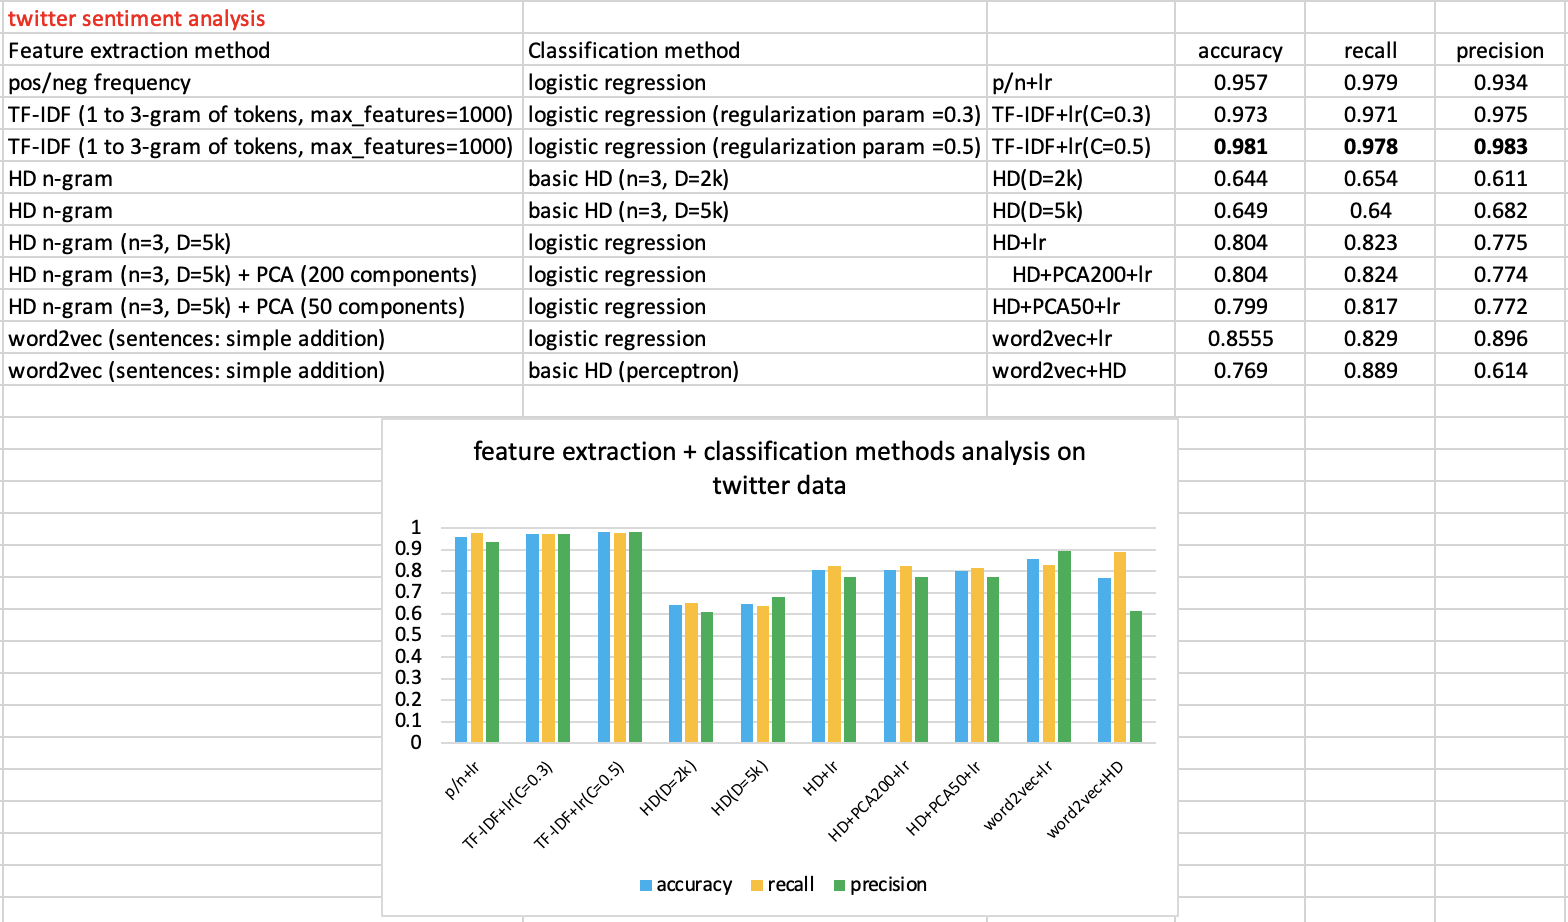

<br><br>

In [22]:
#importing the libraries, stopwords, etc.
import nltk
import numpy as np
nltk.download('stopwords')
#from utils import process_tweet, build_freqs
# importing the libraries 
import re #for regular expression operations
import string #for string operations
from nltk.corpus import stopwords #for importing stopwords
from nltk.stem import PorterStemmer #for importing stemmer 
from nltk.tokenize import TweetTokenizer #for importing tweet tokenizer
from sklearn.feature_extraction.text import CountVectorizer
from itertools import islice #iter in dictionary
from keras.preprocessing import image #for plotting the wordcloud
import seaborn as sns
import gc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import log_loss,confusion_matrix,classification_report,roc_curve,auc
from nltk.tokenize import word_tokenize
from scipy import sparse
from nltk.corpus import twitter_samples

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/fatemeh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#processing text: removing stopwords, punctuation. Doing stemming and tokenizing
def process_tweet(review):
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    review_tokens = review.split()

    cleaned_review = []
    for word in review_tokens:
        if (word not in stopwords_english and  # remove stopwords
                word not in string.punctuation):  # remove punctuation
            stem_word = stemmer.stem(word)  # stemming word
            cleaned_review.append(stem_word)
    return cleaned_review

In [3]:
def extract_features(tweet, freqs, process_tweet=process_tweet):
    word_l = process_tweet(tweet)
    x = np.zeros((1, 3)) 
    x[0,0] = 1 
    for word in word_l:
        
        x[0,1] += freqs.get((word, 1), 0)
        
        x[0,2] += freqs.get((word, 0), 0)
        
    assert(x.shape == (1, 3))
    return x

In [4]:
def build_freqs(tweets, ys):
    yslist = np.squeeze(ys).tolist()
    freqs = {}
    for y, tweet in zip(yslist, tweets):
        for word in process_tweet(tweet):
            pair = (word, y)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1
    return freqs

In [5]:
def gradientDescent(x, y, theta, alpha, num_iters):
    m = len(x)
    for i in range(0, num_iters):
        z = np.dot(x, theta)
        h = sigmoid(z)

        J = -1./m*(np.dot(y.transpose(), np.log(h)) + np.dot((1-y).transpose(), np.log(1-h)))
        theta = theta - alpha/m*np.dot(x.transpose(), (h-y))
    return float(J), theta

In [6]:
# UNQ_C4 GRADED FUNCTION: predict_tweet
def predict_tweet(tweet, freqs, theta):
    x = extract_features(tweet, freqs)
    y_pred = sigmoid(np.dot(x, theta))    
    return y_pred

In [7]:
def sigmoid(z): 
    h = None
    h = 1./(1+np.power(np.e, -z))
    return h

In [8]:
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')

In [9]:
all_positive_tweets = twitter_samples.strings('positive_tweets.json')
all_negative_tweets = twitter_samples.strings('negative_tweets.json')

test_pos = all_positive_tweets[4000:]
train_pos = all_positive_tweets[:4000]
test_neg = all_negative_tweets[4000:]
train_neg = all_negative_tweets[:4000]

train_x = train_pos + train_neg 
test_x = test_pos + test_neg
# combinung positive and negative labels
train_y = np.append(np.ones((len(train_pos), 1)), np.zeros((len(train_neg), 1)), axis=0)
test_y = np.append(np.ones((len(test_pos), 1)), np.zeros((len(test_neg), 1)), axis=0)

In [10]:
# shape of train and test sets
print("train_y.shape = " + str(train_y.shape))
print("test_y.shape = " + str(test_y.shape))

train_y.shape = (8000, 1)
test_y.shape = (2000, 1)


In [11]:
len(train_x)

8000

In [12]:
freqs = build_freqs(train_x, train_y)

In [48]:
freqs

{('#followfriday', 1.0): 23,
 ('@france_int', 1.0): 1,
 ('@pkuchly57', 1.0): 1,
 ('@milipol_pari', 1.0): 1,
 ('top', 1.0): 28,
 ('engag', 1.0): 7,
 ('member', 1.0): 13,
 ('commun', 1.0): 25,
 ('week', 1.0): 66,
 (':)', 1.0): 2632,
 ('@lamb2ja', 1.0): 1,
 ('hey', 1.0): 50,
 ('james!', 1.0): 3,
 ('how', 1.0): 18,
 ('odd', 1.0): 2,
 (':/', 1.0): 5,
 ('pleas', 1.0): 68,
 ('call', 1.0): 26,
 ('contact', 1.0): 4,
 ('centr', 1.0): 1,
 ('02392441234', 1.0): 1,
 ('abl', 1.0): 6,
 ('assist', 1.0): 1,
 ('mani', 1.0): 25,
 ('thanks!', 1.0): 15,
 ('@despiteoffici', 1.0): 1,
 ('listen', 1.0): 14,
 ('last', 1.0): 38,
 ('night', 1.0): 41,
 ('as', 1.0): 3,
 ('you', 1.0): 91,
 ('bleed', 1.0): 2,
 ('amaz', 1.0): 33,
 ('track.', 1.0): 1,
 ('when', 1.0): 10,
 ('scotland?!', 1.0): 1,
 ('@97side', 1.0): 1,
 ('congrat', 1.0): 13,
 ('yeaaaah', 1.0): 1,
 ('yippppy!!!', 1.0): 1,
 ('accnt', 1.0): 1,
 ('verifi', 1.0): 2,
 ('rqst', 1.0): 1,
 ('succeed', 1.0): 1,
 ('got', 1.0): 57,
 ('blue', 1.0): 8,
 ('tick', 1.0):

In [49]:
def test_logistic_regression(test_x, test_y, freqs, theta, predict_tweet=predict_tweet):
    y_hat = []
    
    for tweet in test_x:
        y_pred = predict_tweet(tweet, freqs, theta)
        
        if y_pred > 0.5:
            y_hat.append(1.0)
        else:
            y_hat.append(0.0)
    test_y = [int(i) for i in test_y]
    accuracy = np.sum(y_hat ==test_y)/len(test_y)
    return accuracy

In [50]:
X = np.zeros((len(train_x), 3))
for i in range(len(train_x)):
    X[i, :]= extract_features(train_x[i], freqs)

Y = train_y
J, theta = gradientDescent(X, Y, np.zeros((3, 1)), 1e-9, 1500)

In [51]:
y_hat = []

for tweet in test_x:
    y_pred = predict_tweet(tweet, freqs, theta)

    if y_pred > 0.5:
        y_hat.append(1.0)
    else:
        y_hat.append(0.0)

In [98]:
len(test_y), len(y_hat)

(2000, 2000)

In [ ]:
+ - -> lr

In [100]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

print("test evluation")
acc = accuracy_score(y_hat, test_y)
recall = recall_score(y_hat, test_y)
precision  = precision_score(y_hat, test_y)
print("acc: {} | recall: {} | precision: {}".format(acc, recall, precision))

test evluation
acc: 0.957 | recall: 0.9790356394129979 | precision: 0.934


<span style="color:red;">TF-IDF</span>

In [374]:
from sklearn.feature_extraction.text import TfidfTransformer
def all_features_tfidtransformer(corpus, n_range):
    """
    input: corpus: gets a corpus of data 
    input: n_range: range of the n-gram length
    output: derived features 
    """
    assert type(n_range) == tuple
    vectorizer = TfidfVectorizer(ngram_range=(n_range[0], n_range[1]), stop_words='english') #less than equal to 1
    vectorizer.fit_transform(corpus)
    features = vectorizer.get_feature_names()
    return features

features_1_gram = all_features_tfidtransformer(train_x, (1, 1))
features_1to2_gram = all_features_tfidtransformer(train_x, (1, 2))
features_1to3_gram = all_features_tfidtransformer(train_x, (1, 3))
features_1to4_gram = all_features_tfidtransformer(train_x, (1, 4))
features_1to5_gram = all_features_tfidtransformer(train_x, (1, 5))
print("There are {} 1-gram features in the training data.".format(len(features_1_gram)))
print("There are {} 2-gram features in the training data.".format(len(features_1to2_gram)-len(features_1_gram)))
print("There are {} 3-gram features in the training data.".format(len(features_1to3_gram)-len(features_1to2_gram)))
print("There are {} 4-gram features in the training data.".format(len(features_1to4_gram)-len(features_1to3_gram)))
print("There are {} 5-gram features in the training data.".format(len(features_1to5_gram)-len(features_1to4_gram)))

/Users/fatemeh/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


There are 17223 1-gram features in the training data.
There are 35174 2-gram features in the training data.
There are 30577 3-gram features in the training data.
There are 24411 4-gram features in the training data.
There are 19136 5-gram features in the training data.


In [375]:
vect_word = TfidfVectorizer(max_features=20000, lowercase=True, analyzer='word',
                        stop_words= 'english',ngram_range=(1,3),dtype=np.float32)
vect_char = TfidfVectorizer(max_features=40000, lowercase=True, analyzer='char',
                        stop_words= 'english',ngram_range=(1, 3),dtype=np.float32)
# Word ngram vector
tr_vect = vect_word.fit_transform(train_x)
ts_vect = vect_word.transform(test_x)

# Character n gram vector
tr_vect_char = vect_char.fit_transform(train_x)
ts_vect_char = vect_char.transform(test_x)
gc.collect()

X = sparse.hstack([tr_vect, tr_vect_char])
x_test = sparse.hstack([ts_vect, ts_vect_char])

def TfidfVectorizer_funct(trainx, devx, ngram_range):
    v_word = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word',
                            stop_words= 'english',ngram_range=ngram_range,dtype=np.float32)
    v_c = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='char',
                            stop_words= 'english',ngram_range=ngram_range,dtype=np.float32)
    t_v = v_word.fit_transform(trainx) # Word ngram vector for training data
    s_v = v_word.transform(devx) # Word ngram vector for dev data
    t_v_char = vect_char.fit_transform(trainx) # Character n gram vector for training data
    s_v_char = vect_char.transform(devx) # Character n gram vector for dev data
    X = sparse.hstack([t_v, t_v_char])
    dev_x = sparse.hstack([s_v, s_v_char])
    return X, dev_x

In [376]:
ngram_range=(1,2)
v_word = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word',
                        stop_words= 'english',ngram_range=(1,2),dtype=np.float32)
v_word
v_c = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='char',
                        stop_words= 'english',ngram_range=ngram_range,dtype=np.float32)
t_v = v_word.fit_transform(train_x) # Word ngram vector for training data
s_v = v_word.transform(test_x) # Word ngram vector for dev data
t_v_char = vect_char.fit_transform(train_x) # Character n gram vector for training data
s_v_char = vect_char.transform(test_x) # Character n gram vector for dev data
X = sparse.hstack([t_v, t_v_char])
dev_x = sparse.hstack([s_v, s_v_char])

In [23]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score

def return_val(x):
    if x <0.5:
        return 0
    return 1
        
def eval_tfidvect(c, ngram_range, trainx, devx, trainy, testy):
    X, dev_x = TfidfVectorizer_funct(trainx, devx, ngram_range)
    prd = []
    cv_score =[]
    lr = LogisticRegression(C=c)
    lr.fit(X,trainy)
    prd = lr.predict_proba(dev_x)[:,1]
    prd_val = [return_val(x) for x in prd]
    print("test evluation")
    acc = accuracy_score(testy, prd_val)
    recall = recall_score(testy, prd_val)
    precision  = precision_score(testy, prd_val)
    print("acc: {} | recall: {} | precision: {}".format(acc, recall, precision))
    prd = lr.predict_proba(X)[:,1]
    prd_val = [return_val(x) for x in prd]   
    print("training evluation")
    acc = accuracy_score(trainy, prd_val)
    recall = recall_score(trainy, prd_val)
    precision  = precision_score(trainy, prd_val)
    print("acc: {} | recall: {} | precision: {}".format(np.round(acc, 2), np.round(recall, 2), np.round(precision, 2)))

In [121]:
eval_tfidvect(0.3, (1,1), train_x, test_x, train_y, test_y)

/Users/fatemeh/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


test evluation
acc: 0.9735 | recall: 0.971 | precision: 0.9758793969849247
training evluation
acc: 0.99 | recall: 0.99 | precision: 0.99


In [124]:
import gensim.downloader as api
#model = api.load('word2vec-google-news-300')

In [54]:
ngram_range=(1,3)
v_word = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word',
                        stop_words= 'english',ngram_range=ngram_range,dtype=np.float32)
v_word
v_c = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='char',
                        stop_words= 'english',ngram_range=ngram_range,dtype=np.float32)
t_v = v_word.fit_transform(train_x) # Word ngram vector for training data
s_v = v_word.transform(test_x) # Word ngram vector for dev data
t_v_char = vect_char.fit_transform(train_x) # Character n gram vector for training data
s_v_char = vect_char.transform(test_x) # Character n gram vector for dev data
X = sparse.hstack([t_v, t_v_char])
dev_x = sparse.hstack([s_v, s_v_char])

In [60]:
eval_tfidvect(0.3, (1,3), train_x, test_x, train_y, test_y)

/Users/fatemeh/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


test evluation
acc: 0.9735 | recall: 0.971 | precision: 0.9758793969849247
training evluation
acc: 0.99 | recall: 0.99 | precision: 0.99


In [61]:
eval_tfidvect(0.5, (1,3), train_x, test_x, train_y, test_y)

/Users/fatemeh/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


test evluation
acc: 0.981 | recall: 0.978 | precision: 0.9839034205231388
training evluation
acc: 0.99 | recall: 0.99 | precision: 0.99


<span style="color:red;">Basic n-gram HD</span>

In [252]:
alphabet = {' ': 1}
for sentence in train_x:
    words = sentence.split(" ")
    for w in words:
        for c in w:
            if c not in alphabet:
                alphabet[c] = 1
            else:
                alphabet[c] += 1
#     result = {}
#     for k,v in alphabet.items():
#         if v <= 10:
#             pass
#         else:
#             result[k] = v

In [248]:
# alphabet = {' ': 1}
# for sentence in test_x:
#     words = sentence.split(" ")
#     for w in words:
#         for c in w:
#             if c not in alphabet_test:
#                 alphabet_test[c] = 1
#             else:
#                 alphabet_test[c] += 1

In [304]:
def initialize_vecs(alphabet, D):
    init_vecs = {}
    for c in alphabet:
        binary_vec = np.random.choice([0, 1], size=(D,), p=[1/2, 1/2])
        init_vecs[c] = binary_vec
    return init_vecs
init_vecs = initialize_vecs(alphabet, D)
init_vecs["a"]

array([0, 0, 1, ..., 1, 0, 1])

In [307]:
def HD_encode_sentence(sentence, init_vecs, D, n):
    enc_hvs = np.array([0]*D)
    for j in range(len(sentence) - (n-1)):
        if sentence[j] not in init_vecs:
            init_vecs[sentence[j]] = np.array([0]*D)
        for k in range(0, n):
            if k == 0:
                temp = np.roll(init_vecs[sentence[j]], 0)
            else:
                temp = np.multiply(np.roll(init_vecs[sentence[j]], k), temp)
            enc_hvs += temp
    return enc_hvs
HD_encode_sentence(sentence, init_vecs, D, n)

array([117,  48,  78, ..., 193, 179,  76])

In [268]:
def encode_all_sentences(x, D, n, init_vecs):
    encoded_sentences = []
#     i = 0
    for sentence in x:
#         i+=1
#         print(i)
        encoded = HD_encode_sentence(sentence, init_vecs, D, n)
        encoded_sentences.append(encoded)
    return encoded_sentences

In [269]:
encoded_training = encode_all_sentences(train_x, D=2000, n=3, init_vecs=init_vecs)
encoded_test = encode_all_sentences(test_x, D=2000, n=3, init_vecs=init_vecs)

In [34]:
def train_HD(encoded_training, train_y, D):
    class_hvs = [[0.] * D] * (max(train_y) + 1)
    for i in range(0, len(encoded_training)):
        if train_y[i] == 1:
            class_hvs[1] += encoded_training[i] #positive
        else:
            class_hvs[0] += encoded_training[i] #negative
    return class_hvs
#class_hvs = train_HD(encoded_training, train_y, D)

In [285]:
class_norms = [np.linalg.norm(hv) for hv in class_hvs]

In [288]:
class_hvs, class_norms

([array([215427., 175077., 172702., ..., 354096., 411651., 161765.]),
  array([262648., 212752., 201126., ..., 402801., 466047., 193432.])],
 [10008887.821270952, 11581680.497773413])

In [57]:
def max_match(class_hvs, enc_hv):
    max_score = -np.inf
    max_index = -1
    for i in range(len(class_hvs)):
        score = np.matmul(class_hvs[i], enc_hv) / class_norms[i]
        if score > max_score:
            max_score = score
            max_index = i
    return max_index

In [293]:
def predict_HD(encoded_test, test_y, class_hvs):
    preds = []
    for i in range(0, len(encoded_test)):
        y_hat = max_match(class_hvs, encoded_test[i])
        preds.append(y_hat)
    return preds

In [294]:
preds = predict_HD(encoded_test, test_y, class_hvs)

In [292]:
len(encoded_test)

2000

In [296]:
print("test evluation")
acc = accuracy_score(preds, test_y)
recall = recall_score(preds, test_y)
precision  = precision_score(preds, test_y)
print("acc: {} | recall: {} | precision: {}".format(acc, recall, precision))

test evluation
acc: 0.6445 | recall: 0.654876741693462 | precision: 0.611


<span style="color:red;">Basic n-gram HD with D=10000</span>

In [300]:
alphabet = {' ': 1}
for sentence in train_x:
    words = sentence.split(" ")
    for w in words:
        for c in w:
            if c not in alphabet:
                alphabet[c] = 1
            else:
                alphabet[c] += 1

In [315]:
def do_HD(D, n, train_x, test_x, alphabet):
    init_vecs = initialize_vecs(alphabet, D)
    print(D)
    encoded_training = encode_all_sentences(train_x, D, n, init_vecs=init_vecs)
    print(D)
    encoded_test = encode_all_sentences(test_x, D, n, init_vecs=init_vecs)
    class_hvs = train_HD(encoded_training, train_y, D)
    class_norms = [np.linalg.norm(hv) for hv in class_hvs]
    preds = predict_HD(encoded_test, test_y, class_hvs)
    print("test evluation")
    acc = accuracy_score(preds, test_y)
    recall = recall_score(preds, test_y)
    precision  = precision_score(preds, test_y)
    print("acc: {} | recall: {} | precision: {}".format(acc, recall, precision))

In [316]:
do_HD(5000, 3, train_x, test_x, alphabet)

5000
5000
test evluation
acc: 0.6495 | recall: 0.64037558685446 | precision: 0.682


In [317]:
do_HD(10000, 3, train_x, test_x, alphabet)

10000
10000
test evluation
acc: 0.6315 | recall: 0.5908776779543884 | precision: 0.855


In [319]:
do_HD(2000, 4, train_x, test_x, alphabet)

2000
2000
test evluation
acc: 0.512 | recall: 0.5060728744939271 | precision: 1.0


In [320]:
import string
alphabet = list(string.ascii_lowercase)

In [321]:
def do_HD(D, n, train_x, test_x, alphabet):
    init_vecs = initialize_vecs(alphabet, D)
    print(D)
    encoded_training = encode_all_sentences(train_x, D, n, init_vecs=init_vecs)
    print(D)
    encoded_test = encode_all_sentences(test_x, D, n, init_vecs=init_vecs)
    class_hvs = train_HD(encoded_training, train_y, D)
    class_norms = [np.linalg.norm(hv) for hv in class_hvs]
    preds = predict_HD(encoded_test, test_y, class_hvs)
    print("test evluation")
    acc = accuracy_score(preds, test_y)
    recall = recall_score(preds, test_y)
    precision  = precision_score(preds, test_y)
    print("acc: {} | recall: {} | precision: {}".format(acc, recall, precision))

In [322]:
do_HD(5000, 3, train_x, test_x, alphabet)

5000
5000
test evluation
acc: 0.504 | recall: 0.5020120724346077 | precision: 0.998


In [327]:
#processing text: removing stopwords, punctuation. Doing stemming and tokenizing
def process_tweet(review):
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    review_tokens = review.split()

    cleaned_review = []
    for word in review_tokens:
        if (word not in stopwords_english and  # remove stopwords
                word not in string.punctuation):  # remove punctuation
            word = word.lower()
            stem_word = stemmer.stem(word)  # stemming word
            cleaned_review.append(stem_word)
    return cleaned_review

In [337]:
processed = []
for t in train_x:
    p = process_tweet(t)
    t = ""
    for i in p:
        t += i + " "
    processed.append(t)

In [338]:
def do_HD(D, n, train_x, test_x, alphabet):
    init_vecs = initialize_vecs(alphabet, D)
    print(D)
    encoded_training = encode_all_sentences(train_x, D, n, init_vecs=init_vecs)
    print(D)
    encoded_test = encode_all_sentences(test_x, D, n, init_vecs=init_vecs)
    class_hvs = train_HD(encoded_training, train_y, D)
    class_norms = [np.linalg.norm(hv) for hv in class_hvs]
    preds = predict_HD(encoded_test, test_y, class_hvs)
    print("test evluation")
    acc = accuracy_score(preds, test_y)
    recall = recall_score(preds, test_y)
    precision  = precision_score(preds, test_y)
    print("acc: {} | recall: {} | precision: {}".format(acc, recall, precision))

In [339]:
do_HD(5000, 3, processed, test_x, alphabet)

5000
5000
test evluation
acc: 0.504 | recall: 0.5020120724346077 | precision: 0.998


In [340]:
do_HD(5000, 3, train_x, test_x, alphabet)

5000
5000
test evluation
acc: 0.504 | recall: 0.5020120724346077 | precision: 0.998


<span style="color:red;">Is it encoding or is it feature extraction based on the above results that is not working well?</span>

In [358]:
X[0]

array([[0, 1, 1, ..., 1, 0, 1]])

In [373]:
import numpy as np
from sklearn.linear_model import LogisticRegression

# X = [[0, 1, 1, 0], [0, 1, 1, 0], [1, 1, 1, 0], [0, 0, 0, 1], [1, 0, 1, 0], [1, 0, 1, 1], [0, 0, 1, 0], [1, 1 , 1, 1]]
# y = [0,1, 1, 0, 1, 1, 1, 0]

X = encoded_training
y = train_y

model = LogisticRegression(solver='liblinear')
model = model.fit(X,y)

print('coef', model.coef_)
print('intercept', model.intercept_)

/Users/fatemeh/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


coef [[-0.00594298 -0.01207994  0.01376144 ...  0.01557845  0.01316345
  -0.02657414]]
intercept [-0.74412257]


In [377]:
#!pip install scikit-learn  -U
preds = model.predict(encoded_test)

In [378]:
print("test evluation")
acc = accuracy_score(preds, test_y)
recall = recall_score(preds, test_y)
precision  = precision_score(preds, test_y)
print("acc: {} | recall: {} | precision: {}".format(acc, recall, precision))

test evluation
acc: 0.8045 | recall: 0.8235919234856536 | precision: 0.775


In [376]:
len(pred)

2000

In [374]:
# from sklearn.datasets import load_iris
# from sklearn.linear_model import LogisticRegression
# clf = LogisticRegression(random_state=0).fit(encoded_training, train_y)
# pred = clf.predict(encoded_test)

<span style="color:red;">HD encoding + PCA + lr </span>

In [389]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50)
X_train = pca.fit_transform(encoded_training)
X_test = pca.transform(encoded_test)

model = LogisticRegression(solver='liblinear')
model = model.fit(X_train,y)
preds = model.predict(X_test)

print("test evluation")
acc = accuracy_score(preds, test_y)
recall = recall_score(preds, test_y)
precision  = precision_score(preds, test_y)
print("acc: {} | recall: {} | precision: {}".format(acc, recall, precision))

/Users/fatemeh/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


test evluation
acc: 0.7995 | recall: 0.816931216931217 | precision: 0.772


In [388]:
from sklearn.decomposition import PCA

pca = PCA(n_components=200)
X_train = pca.fit_transform(encoded_training)
X_test = pca.transform(encoded_test)

model = LogisticRegression(solver='liblinear')
model = model.fit(X_train,y)
preds = model.predict(X_test)

print("test evluation")
acc = accuracy_score(preds, test_y)
recall = recall_score(preds, test_y)
precision  = precision_score(preds, test_y)
print("acc: {} | recall: {} | precision: {}".format(acc, recall, precision))

/Users/fatemeh/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


test evluation
acc: 0.8045 | recall: 0.8242811501597445 | precision: 0.774


<span style="color:red;"> freq_based + HD </span>

In [412]:
X = []
for i in range(len(train_x)):
    t = extract_features(train_x[i], freqs)
    X.append(t.ravel().tolist())

In [510]:
# D = 2   
# a = 0 
# b = 0
# class_hvs = [[0.] * D] * (max(y_train) + 1)
# for i in range(0, len(X)):
#     if train_y[i] == 1:
#         a+= 1
#         class_hvs[0][0] += X[i][1] #positive
#         class_hvs[0][1] += X[i][2] #positive
#     else:
#         b+= 1
#         class_hvs[1][0] += X[i][1] #negative
#         class_hvs[1][1] += X[i][2] #negative
# class_hvs

In [457]:
max_pos = 0
min_pos = np.inf
max_neg = 0
min_neg = np.inf
for i in range(len(X)):
    if X[i][1] > max_pos:
        max_pos = X[i][1]
    if X[i][1] < min_pos:
        min_pos = X[i][1]
    if X[i][0] > max_neg:
        max_neg = X[i][1]
    if X[i][1] < min_neg:
        min_neg = X[i][1]   
min_neg, max_neg, min_pos, max_pos

(0.0, 2797.0, 0.0, 18555.0)

In [ ]:
#Dont know how to use these 2D vecs as input to HD training

In [ ]:
#.

In [ ]:
#.

In [ ]:
#.

<span style="color:red;">TF - IDF + HD </span>

In [14]:
n_range = (1, 3)
vectorizer = TfidfVectorizer(ngram_range=(n_range[0], n_range[1]), stop_words='english') #less than equal to 1
vectorizer.fit_transform(train_x)
features = vectorizer.get_feature_names()

tfidf_matrix = vectorizer.fit_transform(train_x)
npm_tfidf = tfidf_matrix.todense()
document_1_vector = npm_tfidf[0]

/Users/fatemeh/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
#tf_idf_vectors = []
for i in range(0, len(train_x)):
    doc_vector = npm_tfidf[i]
    tf_idf_vectors.append(doc_vector[0].tolist()[0])

In [19]:
tf_idf_vectors.append(doc_vector[-1].tolist()[0])

In [21]:
len(tf_idf_vectors[0])

82974

In [22]:
len(tf_idf_vectors[1])

82974

In [23]:
len(tf_idf_vectors[2])

82974

In [ ]:
tfidf_matrix = vectorizer.fit_transform(test_x)
npm_tfidf = tfidf_matrix.todense()
test_tf_idf_vectors = []
for i in range(0, len(test_x)):
    if i %100 == 0:
        print(i)
    doc_vector = npm_tfidf[i]
    test_tf_idf_vectors.append(doc_vector[0].tolist()[0])

In [45]:
class_hvs = [[0.] * len(tf_idf_vectors)] * (2)
for i in range(0, len(tf_idf_vectors)):
    if train_y[i] == 1:
        class_hvs[1] += tf_idf_vectors[i] #positive
    else:
        class_hvs[0] += tf_idf_vectors[i] #negative

In [52]:
class_norms = [np.linalg.norm(hv) for hv in class_hvs]

In [53]:
class_norms

[89.35323161475466, 89.35323161475466]

In [183]:
preds = []
for i in range(0, 1):
    max_score = -np.inf
    max_index = -1
    for j in range(len(class_hvs)):
        score = np.matmul(class_hvs[j], test_tf_idf_vectors) / class_norms[j]
        if score > max_score:
            max_score = score
            max_index = j
            preds.append(max_index)

NameError: name 'test_tf_idf_vectors' is not defined

In [ ]:
np.dot(class_hvs[0], test_tf_idf_vectors) / class_norms[j]

In [ ]:
#max_match(class_hvs, test_tf_idf_vectors[0])

In [62]:
len(preds)

0

In [62]:
# print("test evluation")
# acc = accuracy_score(preds, test_y)
# recall = recall_score(preds, test_y)
# precision  = precision_score(preds, test_y)
# print("acc: {} | recall: {} | precision: {}".format(acc, recall, precision))

<span style="color:red;">CNN</span>

<span style="color:red;">word2vec encoding + HD</span>

In [21]:
def process_tweet(review):
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    review_tokens = review.split()

    cleaned_review = []
    for word in review_tokens:
        if (word not in stopwords_english and  # remove stopwords
                word not in string.punctuation):  # remove punctuation
            stem_word = stemmer.stem(word)  # stemming word
            cleaned_review.append(stem_word)
    return cleaned_review
cleaned_review = []
for sentence in train_x:
    cleaned_review.append(process_tweet(sentence))
sentences = cleaned_review

# Import the built-in logging module and configure it so that Word2Vec 
# creates nice output messages
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    level=logging.INFO)

# Set values for various parameters
num_features = 300    # Word vector dimensionality                      
min_word_count = 40   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model (this will take some time)
from gensim.models import word2vec
print ("Training model...")
w2v_model = word2vec.Word2Vec(sentences, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)

# If you don't plan to train the model any further, calling 
# init_sims will make the model much more memory-efficient.
w2v_model.init_sims(replace=True)

# It can be helpful to create a meaningful model name and 
# save the model for later use. You can load it later using Word2Vec.load()
model_name = "300features_40minwords_10context"
w2v_model.save(model_name)


v = []
for i in range(len(sentences)):
    encoded_sentences_vec = np.zeros(300)
    for w in sentences[i]:
        vec = np.zeros(300)
        try:
            vec = w2v_model[w]
        except:
            pass
        encoded_sentences_vec =  [j+k for j,k in zip(vec, encoded_sentences_vec)]
    v.append(encoded_sentences_vec)

v_string = ''
for i in range(len(v)):
    v_string += str(v[i]) + "\n"
with open("train_x.txt", "w") as output:
    output.write(str(v_string))
    
class_hvs = [[0.] * 300] * (2)
for i in range(0, len(v)):
    if train_y[i] == 1:
        class_hvs[1] = [m+n for m,n in zip(v[i],class_hvs[1])] #positive
    else:
        class_hvs[0] = [m+n for m,n in zip(v[i],class_hvs[0])] #negative

        
test_v = []
for i in range(len(test_x)):
    test_encoded_sentences_vec = np.zeros(300)
    for w in cleaned_test[i]:
        vec = np.zeros(300)
        try:
            vec = w2v_model[w]
        except:
            pass
        test_encoded_sentences_vec =  [j+k for j,k in zip(vec, test_encoded_sentences_vec)]
    test_v.append(test_encoded_sentences_vec)

NameError: name 'PorterStemmer' is not defined

In [45]:
def process_tweet(review):
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    review_tokens = review.split()

    cleaned_review = []
    for word in review_tokens:
        if (word not in stopwords_english and  # remove stopwords
                word not in string.punctuation):  # remove punctuation
            stem_word = stemmer.stem(word)  # stemming word
            cleaned_review.append(stem_word)
    return cleaned_review

In [14]:
train_x[0]

'#FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)'

In [15]:
cleaned_review = []
for sentence in train_x:
    cleaned_review.append(process_tweet(sentence))

In [16]:
sentences = cleaned_review

In [17]:
# Import the built-in logging module and configure it so that Word2Vec 
# creates nice output messages
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    level=logging.INFO)

# Set values for various parameters
num_features = 300    # Word vector dimensionality                      
min_word_count = 40   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model (this will take some time)
from gensim.models import word2vec
print ("Training model...")
w2v_model = word2vec.Word2Vec(sentences, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)

# If you don't plan to train the model any further, calling 
# init_sims will make the model much more memory-efficient.
w2v_model.init_sims(replace=True)

# It can be helpful to create a meaningful model name and 
# save the model for later use. You can load it later using Word2Vec.load()
model_name = "300features_40minwords_10context"
w2v_model.save(model_name)

2022-04-20 21:55:14,924 : INFO : collecting all words and their counts
2022-04-20 21:55:14,925 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-04-20 21:55:14,942 : INFO : collected 20228 word types from a corpus of 67190 raw words and 8000 sentences
2022-04-20 21:55:14,943 : INFO : Loading a fresh vocabulary
2022-04-20 21:55:14,951 : INFO : effective_min_count=40 retains 217 unique words (1% of original 20228, drops 20011)
2022-04-20 21:55:14,952 : INFO : effective_min_count=40 leaves 29263 word corpus (43% of original 67190, drops 37927)
2022-04-20 21:55:14,955 : INFO : deleting the raw counts dictionary of 20228 items
2022-04-20 21:55:14,956 : INFO : sample=0.001 downsamples 88 most-common words
2022-04-20 21:55:14,956 : INFO : downsampling leaves estimated 16098 word corpus (55.0% of prior 29263)
2022-04-20 21:55:14,958 : INFO : estimated required memory for 217 words and 300 dimensions: 629300 bytes
2022-04-20 21:55:14,959 : INFO : resetting layer we

Training model...


2022-04-20 21:55:15,135 : INFO : worker thread finished; awaiting finish of 3 more threads
2022-04-20 21:55:15,138 : INFO : worker thread finished; awaiting finish of 2 more threads
2022-04-20 21:55:15,140 : INFO : worker thread finished; awaiting finish of 1 more threads
2022-04-20 21:55:15,141 : INFO : worker thread finished; awaiting finish of 0 more threads
2022-04-20 21:55:15,142 : INFO : EPOCH - 5 : training on 67190 raw words (16160 effective words) took 0.0s, 900123 effective words/s
2022-04-20 21:55:15,143 : INFO : training on a 335950 raw words (80578 effective words) took 0.1s, 592183 effective words/s
2022-04-20 21:55:15,143 : WARNING : under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay
2022-04-20 21:55:15,144 : INFO : precomputing L2-norms of word weight vectors
2022-04-20 21:55:15,146 : INFO : saving Word2Vec object under 300features_40minwords_10context, separately None
2022-04-20 21:55:15,147 : INFO : not storing attribute vector

In [18]:
try: 
    model["now!"]
except:
    pass

In [19]:
v = []
for i in range(len(sentences)):
    encoded_sentences_vec = np.zeros(300)
    for w in sentences[i]:
        vec = np.zeros(300)
        try:
            vec = w2v_model[w]
        except:
            pass
        encoded_sentences_vec =  [j+k for j,k in zip(vec, encoded_sentences_vec)]
    v.append(encoded_sentences_vec)

<ipython-input-19-1f62d6cbbd9f>:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vec = w2v_model[w]


In [20]:
len(v), len(v[0])

(8000, 300)

In [23]:
v_string = ''
for i in range(len(v)):
    v_string += str(v[i]) + "\n"

In [29]:
v_string = ''
for i in range(len(v)):
    v_string += str(v[i]) + "\n"
with open("train_x.txt", "w") as output:
    output.write(str(v_string))

In [171]:
class_hvs = [[0.] * 300] * (2)
for i in range(0, len(v)):
    if train_y[i] == 1:
        class_hvs[1] = [m+n for m,n in zip(v[i],class_hvs[1])] #positive
    else:
        class_hvs[0] = [m+n for m,n in zip(v[i],class_hvs[0])] #negative

In [172]:
len(class_hvs[0])

300

In [173]:
class_norms = [np.linalg.norm(hv) for hv in class_hvs]

In [174]:
class_norms

[14505.114343551433, 14696.049648038064]

In [32]:
cleaned_test = []
for sentence in test_x:
    cleaned_test.append(process_tweet(sentence))

In [33]:
#cleaned_test[0]

In [34]:
test_v = []
for i in range(len(test_x)):
    test_encoded_sentences_vec = np.zeros(300)
    for w in cleaned_test[i]:
        vec = np.zeros(300)
        try:
            vec = w2v_model[w]
        except:
            pass
        test_encoded_sentences_vec =  [j+k for j,k in zip(vec, test_encoded_sentences_vec)]
    test_v.append(test_encoded_sentences_vec)

<ipython-input-34-57e37ed52af3>:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vec = w2v_model[w]


In [35]:
v_string = ''
for i in range(len(test_v)):
    v_string += str(test_v[i]) + "\n"
with open("test_x.txt", "w") as output:
    output.write(str(v_string))

In [182]:
len(test_v[0])

300

In [180]:
len(class_hvs[j]), len(test_v)

(300, 2000)

In [37]:
v_string = ''
for i in range(len(train_y)):
    v_string += str(train_y[i]) + "\n"
with open("train_y.txt", "w") as output:
    output.write(str(v_string))

In [196]:
preds = []
for i in range(0, len(test_x)):
    max_score = -np.inf
    max_index = -1
    for j in range(len(class_hvs)):
        score = np.matmul(class_hvs[j], test_v[i]) / class_norms[j]
        if score > max_score:
            max_score = score
            max_index = j
    preds.append(max_index)#inja
print("test evluation")
acc = accuracy_score(preds, test_y)
recall = recall_score(preds, test_y)
precision  = precision_score(preds, test_y)
print("acc: {} | recall: {} | precision: {}".format(acc, recall, precision))

In [197]:
len(test_x), len(preds)

(2000, 2000)

In [198]:
len(preds)

2000

In [199]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

print("test evluation")
acc = accuracy_score(preds, test_y)
recall = recall_score(preds, test_y)
precision  = precision_score(preds, test_y)
print("acc: {} | recall: {} | precision: {}".format(acc, recall, precision))

test evluation
acc: 0.769 | recall: 0.8898550724637682 | precision: 0.614


In [ ]:
lr

In [202]:
model = LogisticRegression(solver='liblinear')
model = model.fit(v,train_y)

#print('coef', model.coef_)
#print('intercept', model.intercept_)
pred_lr = model.predict(test_v)

/Users/fatemeh/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [204]:
print("test evluation")
acc = accuracy_score(pred_lr, test_y)
recall = recall_score(pred_lr, test_y)
precision  = precision_score(pred_lr, test_y)
print("acc: {} | recall: {} | precision: {}".format(acc, recall, precision))

test evluation
acc: 0.8555 | recall: 0.8288621646623496 | precision: 0.896


<span style="color:red;">word2vec + Random Projection + HD</span>

In [37]:
import numpy as np
import pickle
import sys
import time
from copy import deepcopy

def binarize(base_matrix):
	return np.where(base_matrix < 0, -1, 1)

def encoding_rp(X_data, base_matrix, quantize=False):
	enc_hv = []
	for i in range(len(X_data)):
		if i % int(len(X_data)/20) == 0:
			if log:
				sys.stdout.write(str(int(i/len(X_data)*100)) + '% ')
				sys.stdout.flush()
		hv = np.matmul(base_matrix, X_data[i])
		if quantize:
			hv = binarize(hv)
		enc_hv.append(hv)
	return enc_hv

def encoding_idlv(X_data, lvl_hvs, id_hvs, D, bin_len, x_min, L=32):
	enc_hv = []
	for i in range(len(X_data)):
		if i % int(len(X_data)/20) == 0:
			if log:
				sys.stdout.write(str(int(i/len(X_data)*100)) + '% ')
				sys.stdout.flush()
		sum_ = np.array([0] * D)
		for j in range(len(X_data[i])):
			bin_ = min( int((X_data[i][j] - x_min)/bin_len), L-1)
			sum_ += lvl_hvs[bin_]*id_hvs[j]
		enc_hv.append(sum_)
	return enc_hv

def encoding_ngram(X_data, lvl_hvs, D, bin_len, x_min, L=32, N=3, local=False):
	enc_hv = []
	for i in range(len(X_data)):
		if i % int(len(X_data)/20) == 0:
			if log:
				sys.stdout.write(str(int(i/len(X_data)*100)) + '% ')
				sys.stdout.flush()
		sum_ = np.array([0] * D)
		for j in range(len(X_data[i]) - (N-1)):
			for k in range(0, N):
				bin_ = min( int((X_data[i][j+k] - x_min)/bin_len), L-1)
				if k == 0:
					temp = np.roll(lvl_hvs[bin_], 0)
				else:
					temp = np.multiply(np.roll(lvl_hvs[bin_], k), temp)
			if not local:
				temp = np.roll(temp, j)
			sum_ += temp
		enc_hv.append(sum_)
	return enc_hv

def encoding_ngram_idlv(X_data, lvl_hvs, id_hvs, D, bin_len, x_min, L=32, N=3):
	enc_hv = []
	for i in range(len(X_data)):
		if i % int(len(X_data)/20) == 0:
			if log:
				sys.stdout.write(str(int(i/len(X_data)*100)) + '% ')
				sys.stdout.flush()
		sum_ = np.array([0] * D)
		for j in range(len(X_data[i]) - (N-1)):
			for k in range(0, N):
				bin_ = min( int((X_data[i][j+k] - x_min)/bin_len), L-1)
				if k == 0:
					temp = np.roll(lvl_hvs[bin_], 0)
				else:
					temp = np.multiply(np.roll(lvl_hvs[bin_], k), temp)
			temp = temp*id_hvs[j]
			sum_ += temp
		enc_hv.append(sum_)
	return enc_hv

def max_match(class_hvs, enc_hv, class_norms):
		max_score = -np.inf
		max_index = -1
		for i in range(len(class_hvs)):
			score = np.matmul(class_hvs[i], enc_hv) / class_norms[i]
			if score > max_score:
				max_score = score
				max_index = i
		return max_index

def train(X_train, y_train, X_test, y_test, D=4000, alg='rp', epoch=20, alpha=1.0, log_=True, L=32, N=3):
	global log
	log = log_
	local = False
	permvar = np.arange(0, len(X_train))
	np.random.shuffle(permvar)
	X_train = [X_train[i] for i in permvar]
	y_train = [y_train[i] for i in permvar]
	cnt_vld = int(0.2 * len(X_train))
	X_validation = X_train[0:cnt_vld]
	y_validation = y_train[0:cnt_vld]
	X_train = X_train[cnt_vld:]
	y_train = y_train[cnt_vld:]
	
	if alg.lower() == 'rp':
		base_matrix = np.random.rand(D, len(X_train[0]))
		base_matrix = np.where(base_matrix > 0.5, 1, -1)
		base_matrix = np.array(base_matrix, np.int8)
		if log: print('Encoding ' + str(len(X_train)) + ' train data')
		train_enc_hvs = encoding_rp(X_train, base_matrix, quantize=False)
		if log: print('\n\nEncoding ' + str(len(X_validation)) + ' validation data')
		validation_enc_hvs = encoding_rp(X_validation, base_matrix, quantize=False)
		
	elif alg.lower() in ['idlv', 'idhv', 'ngram-idlv', 'ngram-idhv', 'ngram', 'ngram-local']:
		lvl_hvs = []
		temp = [-1]*int(D/2) + [1]*int(D/2)
		np.random.shuffle(temp)
		lvl_hvs.append(temp)
		change_list = np.arange(0, D)
		np.random.shuffle(change_list)
		cnt_toChange = int(D/2 / (L-1))
		for i in range(1, L):
			temp = np.array(lvl_hvs[i-1])
			temp[change_list[(i-1)*cnt_toChange : i*cnt_toChange]] = -temp[change_list[(i-1)*cnt_toChange : i*cnt_toChange]]
			lvl_hvs.append(list(temp))
		lvl_hvs = np.array(lvl_hvs, dtype=np.int8)
		x_min = min( np.min(X_train), np.min(X_validation) )
		x_max = max( np.max(X_train), np.max(X_validation) )
		bin_len = (x_max - x_min)/float(L)	
		if alg.lower() in ['idlv', 'idhv', 'ngram-idlv', 'ngram-idhv']:
			cnt_id = len(X_train[0])
			id_hvs = []
			for i in range(cnt_id):
				temp = [-1]*int(D/2) + [1]*int(D/2)
				np.random.shuffle(temp)
				id_hvs.append(temp)
			id_hvs = np.array(id_hvs, dtype=np.int8)
			if alg.lower() in ['idlv', 'idhv']:
				if log: print('Encoding ' + str(len(X_train)) + ' train data')
				train_enc_hvs = encoding_idlv(X_train, lvl_hvs, id_hvs, D, bin_len, x_min, L)
				if log: print('\n\nEncoding ' + str(len(X_validation)) + ' validation data')
				validation_enc_hvs = encoding_idlv(X_validation, lvl_hvs, id_hvs, D, bin_len, x_min, L)
			elif alg.lower() in ['ngram-idlv', 'ngram-idhv']:
				if log: print('Encoding ' + str(len(X_train)) + ' train data')
				train_enc_hvs = encoding_ngram_idlv(X_train, lvl_hvs, id_hvs, D, bin_len, x_min, L, N)
				if log: print('\n\nEncoding ' + str(len(X_validation)) + ' validation data')
				validation_enc_hvs = encoding_ngram_idlv(X_validation, lvl_hvs, id_hvs, D, bin_len, x_min, L, N)
		elif alg.lower() in ['ngram', 'ngram-local']:
			if alg.lower() == 'ngram-local': local = True
			if log: print('Encoding ' + str(len(X_train)) + ' train data')
			train_enc_hvs = encoding_ngram(X_train, lvl_hvs, D, bin_len, x_min, L, N, local)
			if log: print('\n\nEncoding ' + str(len(X_validation)) + ' validation data')
			validation_enc_hvs = encoding_ngram(X_validation, lvl_hvs, D, bin_len, x_min, L, N, local)
	
	class_hvs = [[0.] * D] * (max(y_train) + 1)
	for i in range(len(train_enc_hvs)):
		class_hvs[y_train[i]] += train_enc_hvs[i]
		#class_hvs[y_train[i]] = [j+k for j,k in zip(train_enc_hvs[i], class_hvs[y_train[i]])]
	class_norms = [np.linalg.norm(hv) for hv in class_hvs]
	class_hvs_best = deepcopy(class_hvs)
	class_norms_best = deepcopy(class_norms)
	
	if epoch > 0:
		acc_max = -np.inf
		if log: print('\n\n' + str(epoch) + ' retraining epochs')
		for i in range(epoch):
			if log:
				sys.stdout.write('epoch ' + str(i) + ': ')
				sys.stdout.flush()
			for j in range(len(train_enc_hvs)):
				predict = max_match(class_hvs, train_enc_hvs[j], class_norms)
				if predict != y_train[j]:
					class_hvs[predict] -= np.multiply(alpha/(1. + epoch/5.), train_enc_hvs[j])
					class_hvs[y_train[j]] += np.multiply(alpha/(1. + epoch/5.), train_enc_hvs[j])
			class_norms = [np.linalg.norm(hv) for hv in class_hvs]
			correct = 0
			for j in range(len(validation_enc_hvs)):
				predict = max_match(class_hvs, validation_enc_hvs[j], class_norms)
				if predict == y_validation[j]:
					correct += 1
			acc = float(correct)/len(validation_enc_hvs)
			if log:
				sys.stdout.write("%.4f " %acc)
				sys.stdout.flush()
			if acc > acc_max:
				acc_max = acc
				class_hvs_best = deepcopy(class_hvs)
				class_norms_best = deepcopy(class_norms)
	start = time.time()
	if log: print('\n\nEncoding ' + str(len(X_test)) + ' test data')
	if alg.lower() == 'rp':
		test_enc_hvs = encoding_rp(X_test, base_matrix, quantize=False)
	elif alg.lower() == 'idhv' or alg.lower() == 'idlv':
		test_enc_hvs = encoding_idlv(X_test, lvl_hvs, id_hvs, D, bin_len, x_min, L)
	elif alg.lower() == 'ngram-idhv' or alg.lower() == 'ngram-idlv':
		test_enc_hvs = encoding_ngram_idlv(X_test, lvl_hvs, id_hvs, D, bin_len, x_min, L, N)
	elif alg.lower() == 'ngram' or alg.lower() == 'ngram-local':
		test_enc_hvs = encoding_ngram(X_test, lvl_hvs, D, bin_len, x_min, L, N, local)
	correct = 0
	for i in range(len(test_enc_hvs)):
		predict = max_match(class_hvs_best, test_enc_hvs[i], class_norms_best)
		if predict == y_test[i]:
			correct += 1
	acc = float(correct)/len(test_enc_hvs)
	#print(time.time() - start)
	return acc
X_train = v
y_train = train_y
X_test = test_x
y_test = test_y

class_hvs = [[0.] * D] * int(max(y_train) + 1)
len(class_hvs), [[0.] * D]* (max(y_train) + 1)

print("test evluation")
acc = accuracy_score(preds, test_y)
recall = recall_score(preds, test_y)
precision  = precision_score(preds, test_y)
print("acc: {} | recall: {} | precision: {}".format(acc, recall, precision))

test evluation


NameError: name 'preds' is not defined

In [91]:
#train(X_train, y_train, X_test, y_test, D=4000, alg='rp', epoch=20, alpha=1.0, log_=True, L=32, N=3)

In [147]:
X_train = v
y_train = train_y
X_test = test_v
y_test = test_y

In [67]:
D = 4000

In [128]:
class_hvs = [[0.] * D] * int(max(y_train) + 1)

In [133]:
len(class_hvs), [[0.] * D]* (max(y_train) + 1)

(1, array([[0., 0., 0., ..., 0., 0., 0.]]))

In [156]:
print("test evluation")
acc = accuracy_score(preds, test_y)
recall = recall_score(preds, test_y)
precision  = precision_score(preds, test_y)
print("acc: {} | recall: {} | precision: {}".format(acc, recall, precision))

test evluation
acc: 0.7365 | recall: 0.8883415435139573 | precision: 0.541


In [158]:
base_matrix = np.random.rand(D, len(X_train[0]))
base_matrix = np.where(base_matrix > 0.5, 1, -1)
base_matrix = np.array(base_matrix, np.int8)
# class_hvs = [[0.] * D] * (max(y_train) + 1)
class_hvs = [[0.] * D] * 2
train_enc_hvs = encoding_rp(X_train, base_matrix, quantize=False)
validation_enc_hvs = encoding_rp(X_test, base_matrix, quantize=False)
D=4000
alg='rp'
epoch=100
alpha=1.0
log_=True
L=32
N=3
for i in range(len(train_enc_hvs)):
    if i%1000 == 0:
        print(np.round(i/len(train_enc_hvs)*100, 2))
    class_hvs[int(y_train[i].astype(int))] += train_enc_hvs[i]
    #class_hvs[y_train[i]] = [j+k for j,k in zip(train_enc_hvs[i], class_hvs[y_train[i]])]
class_norms = [np.linalg.norm(hv) for hv in class_hvs]
class_hvs_best = deepcopy(class_hvs)
class_norms_best = deepcopy(class_norms)

if epoch > 0:
    acc_max = -np.inf
    if log: print('\n\n' + str(epoch) + ' retraining epochs')
    for i in range(epoch):
        if log:
            sys.stdout.write('epoch ' + str(i) + ': ')
            sys.stdout.flush()
        for j in range(len(train_enc_hvs)):
            predict = max_match(class_hvs, train_enc_hvs[j], class_norms)
            if predict != y_train[j]:
                class_hvs[predict] -= np.multiply(alpha/(1. + epoch/5.), train_enc_hvs[j])
                class_hvs[int(y_train[i].astype(int))] += np.multiply(alpha/(1. + epoch/5.), train_enc_hvs[j])
        class_norms = [np.linalg.norm(hv) for hv in class_hvs]
        correct = 0
        for j in range(len(validation_enc_hvs)):
            predict = max_match(class_hvs, validation_enc_hvs[j], class_norms)
            if predict == test_y[j]:
                correct += 1
        acc = float(correct)/len(validation_enc_hvs)
        if log:
            sys.stdout.write("%.4f " %acc)
            sys.stdout.flush()
        if acc > acc_max:
            acc_max = acc
            class_hvs_best = deepcopy(class_hvs)
            class_norms_best = deepcopy(class_norms)
start = time.time()
if log: print('\n\nEncoding ' + str(len(X_test)) + ' test data')
if alg.lower() == 'rp':
    test_enc_hvs = encoding_rp(X_test, base_matrix, quantize=False)
elif alg.lower() == 'idhv' or alg.lower() == 'idlv':
    test_enc_hvs = encoding_idlv(X_test, lvl_hvs, id_hvs, D, bin_len, x_min, L)
elif alg.lower() == 'ngram-idhv' or alg.lower() == 'ngram-idlv':
    test_enc_hvs = encoding_ngram_idlv(X_test, lvl_hvs, id_hvs, D, bin_len, x_min, L, N)
elif alg.lower() == 'ngram' or alg.lower() == 'ngram-local':
    test_enc_hvs = encoding_ngram(X_test, lvl_hvs, D, bin_len, x_min, L, N, local)
correct = 0
preds = []
for i in range(len(test_enc_hvs)):
    predict = max_match(class_hvs_best, test_enc_hvs[i], class_norms_best)
    if predict == y_test[i]:
        correct += 1
    preds.append(predict)
acc = float(correct)/len(test_enc_hvs)
#print(time.time() - start)

0% 5% 10% 15% 20% 25% 30% 35% 40% 45% 50% 55% 60% 65% 70% 75% 80% 85% 90% 95% 0% 5% 10% 15% 20% 25% 30% 35% 40% 45% 50% 55% 60% 65% 70% 75% 80% 85% 90% 95% 0.0
12.5
25.0
37.5
50.0
62.5
75.0
87.5


100 retraining epochs
epoch 0: 0.7380 epoch 1: 0.7380 epoch 2: 0.7380 epoch 3: 0.7380 epoch 4: 0.7380 epoch 5: 0.7380 epoch 6: 0.7380 epoch 7: 0.7380 epoch 8: 0.7380 epoch 9: 0.7380 epoch 10: 0.7380 epoch 11: 0.7380 epoch 12: 0.7380 epoch 13: 0.7380 epoch 14: 0.7380 epoch 15: 0.7385 epoch 16: 0.7390 epoch 17: 0.7390 epoch 18: 0.7390 epoch 19: 0.7395 epoch 20: 0.7395 epoch 21: 0.7395 epoch 22: 0.7395 epoch 23: 0.7395 epoch 24: 0.7395 epoch 25: 0.7395 epoch 26: 0.7395 epoch 27: 0.7400 epoch 28: 0.7405 epoch 29: 0.7405 epoch 30: 0.7405 epoch 31: 0.7405 epoch 32: 0.7405 epoch 33: 0.7405 epoch 34: 0.7405 epoch 35: 0.7405 epoch 36: 0.7405 epoch 37: 0.7405 epoch 38: 0.7410 epoch 39: 0.7410 epoch 40: 0.7410 epoch 41: 0.7410 epoch 42: 0.7410 epoch 43: 0.7410 epoch 44: 0.7415 epoch 45: 0.7415 epoch 46:

In [160]:
print("test evluation")
acc = accuracy_score(preds, test_y)
recall = recall_score(preds, test_y)
precision  = precision_score(preds, test_y)
print("acc: {} | recall: {} | precision: {}".format(acc, recall, precision))

test evluation
acc: 0.746 | recall: 0.89171974522293 | precision: 0.56


In [2]:
import gensim 
from gensim.models import Word2Vec
from gensim import models

In [23]:
model1 = gensim.models.Word2Vec(train_x, min_count = 1, 
                              size = 100, window = 5)

In [24]:
model1

In [31]:
#train_x

In [28]:
model1.similarity()

In [37]:
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency

import spacy  # For preprocessing

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [38]:
from gensim.models.phrases import Phrases, Phraser


In [41]:
!pwd

/Users/fatemeh/Desktop


In [48]:
import pandas as pd

# Read data from files 
train = pd.read_csv( "/Users/fatemeh/Desktop/labeledTrainData.tsv", header=0, 
 delimiter="\t", quoting=3 )
test = pd.read_csv( "testData.tsv", header=0, delimiter="\t", quoting=3 )
unlabeled_train = pd.read_csv( "unlabeledTrainData.tsv", header=0, 
 delimiter="\t", quoting=3 )

# Verify the number of reviews that were read (100,000 in total)
print ("Read %d labeled train reviews, %d labeled test reviews, " \
 "and %d unlabeled reviews\n" % (train["review"].size,  
 test["review"].size, unlabeled_train["review"].size ))

Read 25000 labeled train reviews, 25000 labeled test reviews, and 50000 unlabeled reviews



In [49]:
# Import various modules for string cleaning
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords

def review_to_wordlist( review, remove_stopwords=False ):
    # Function to convert a document to a sequence of words,
    # optionally removing stop words.  Returns a list of words.
    #
    # 1. Remove HTML
    review_text = BeautifulSoup(review).get_text()
    #  
    # 2. Remove non-letters
    review_text = re.sub("[^a-zA-Z]"," ", review_text)
    #
    # 3. Convert words to lower case and split them
    words = review_text.lower().split()
    #
    # 4. Optionally remove stop words (false by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    #
    # 5. Return a list of words
    return(words)

In [50]:
# Download the punkt tokenizer for sentence splitting
import nltk.data
nltk.download()   

# Load the punkt tokenizer
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

# Define a function to split a review into parsed sentences
def review_to_sentences( review, tokenizer, remove_stopwords=False ):
    # Function to split a review into parsed sentences. Returns a 
    # list of sentences, where each sentence is a list of words
    #
    # 1. Use the NLTK tokenizer to split the paragraph into sentences
    raw_sentences = tokenizer.tokenize(review.strip())
    #
    # 2. Loop over each sentence
    sentences = []
    for raw_sentence in raw_sentences:
        # If a sentence is empty, skip it
        if len(raw_sentence) > 0:
            # Otherwise, call review_to_wordlist to get a list of words
            sentences.append( review_to_wordlist( raw_sentence, \
              remove_stopwords ))
    #
    # Return the list of sentences (each sentence is a list of words,
    # so this returns a list of lists
    return sentences

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


In [60]:
#sentences

In [52]:
sentences = []  # Initialize an empty list of sentences

print ("Parsing sentences from training set")
for review in train["review"]:
    sentences += review_to_sentences(review, tokenizer)

print ("Parsing sentences from unlabeled set")
for review in unlabeled_train["review"]:
    sentences += review_to_sentences(review, tokenizer)

Parsing sentences from training set


/Users/fatemeh/opt/anaconda3/lib/python3.8/site-packages/bs4/__init__.py:329: MarkupResemblesLocatorWarning: "." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
/Users/fatemeh/opt/anaconda3/lib/python3.8/site-packages/bs4/__init__.py:414: MarkupResemblesLocatorWarning: "http://www.happierabroad.com"" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


Parsing sentences from unlabeled set


/Users/fatemeh/opt/anaconda3/lib/python3.8/site-packages/bs4/__init__.py:414: MarkupResemblesLocatorWarning: "http://www.archive.org/details/LovefromaStranger"" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
/Users/fatemeh/opt/anaconda3/lib/python3.8/site-packages/bs4/__init__.py:414: MarkupResemblesLocatorWarning: "http://www.loosechangeguide.com/LooseChangeGuide.html"" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
/Users/fatemeh/opt/anaconda3/lib/python3.8/site-packages/bs4/__init__.py:414: MarkupResemblesLocatorWarning: "http://www.msnbc.msn.com/id/4972055/site/newsweek/"" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like re

In [53]:
# Check how many sentences we have in total - should be around 850,000+
print(len(sentences))
print (sentences[0])
#[u'with', u'all', u'this', u'stuff', u'going', u'down', u'at', u'the', u'moment', u'with', u'mj', u'i', u've', u'started', u'listening', u'to', u'his', u'music', u'watching', u'the', u'odd', u'documentary', u'here', u'and', u'there', u'watched', u'the', u'wiz', u'and', u'watched', u'moonwalker', u'again']

print(sentences[1])
#[u'maybe', u'i', u'just', u'want', u'to', u'get', u'a', u'certain', u'insight', u'into', u'this', u'guy', u'who', u'i', u'thought', u'was', u'really', u'cool', u'in', u'the', u'eighties', u'just', u'to', u'maybe', u'make', u'up', u'my', u'mind', u'whether', u'he', u'is', u'guilty', u'or', u'innocent']

795538
['with', 'all', 'this', 'stuff', 'going', 'down', 'at', 'the', 'moment', 'with', 'mj', 'i', 've', 'started', 'listening', 'to', 'his', 'music', 'watching', 'the', 'odd', 'documentary', 'here', 'and', 'there', 'watched', 'the', 'wiz', 'and', 'watched', 'moonwalker', 'again']
['maybe', 'i', 'just', 'want', 'to', 'get', 'a', 'certain', 'insight', 'into', 'this', 'guy', 'who', 'i', 'thought', 'was', 'really', 'cool', 'in', 'the', 'eighties', 'just', 'to', 'maybe', 'make', 'up', 'my', 'mind', 'whether', 'he', 'is', 'guilty', 'or', 'innocent']


In [55]:
# Import the built-in logging module and configure it so that Word2Vec 
# creates nice output messages
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    level=logging.INFO)

# Set values for various parameters
num_features = 300    # Word vector dimensionality                      
min_word_count = 40   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model (this will take some time)
from gensim.models import word2vec
print ("Training model...")
model = word2vec.Word2Vec(sentences, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)

# If you don't plan to train the model any further, calling 
# init_sims will make the model much more memory-efficient.
model.init_sims(replace=True)

# It can be helpful to create a meaningful model name and 
# save the model for later use. You can load it later using Word2Vec.load()
model_name = "300features_40minwords_10context"
model.save(model_name)

INFO - 11:45:42: collecting all words and their counts
INFO - 11:45:42: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 11:45:42: PROGRESS: at sentence #10000, processed 225803 words, keeping 17776 word types
INFO - 11:45:42: PROGRESS: at sentence #20000, processed 451892 words, keeping 24948 word types
INFO - 11:45:42: PROGRESS: at sentence #30000, processed 671315 words, keeping 30034 word types


Training model...


INFO - 11:45:43: PROGRESS: at sentence #40000, processed 897815 words, keeping 34348 word types
INFO - 11:45:43: PROGRESS: at sentence #50000, processed 1116963 words, keeping 37761 word types
INFO - 11:45:43: PROGRESS: at sentence #60000, processed 1338404 words, keeping 40723 word types
INFO - 11:45:43: PROGRESS: at sentence #70000, processed 1561580 words, keeping 43333 word types
INFO - 11:45:43: PROGRESS: at sentence #80000, processed 1780887 words, keeping 45714 word types
INFO - 11:45:43: PROGRESS: at sentence #90000, processed 2004996 words, keeping 48135 word types
INFO - 11:45:43: PROGRESS: at sentence #100000, processed 2226966 words, keeping 50207 word types
INFO - 11:45:43: PROGRESS: at sentence #110000, processed 2446580 words, keeping 52081 word types
INFO - 11:45:43: PROGRESS: at sentence #120000, processed 2668775 words, keeping 54119 word types
INFO - 11:45:43: PROGRESS: at sentence #130000, processed 2894303 words, keeping 55847 word types
INFO - 11:45:43: PROGRESS: 

INFO - 11:45:50: training model with 4 workers on 16490 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=10
INFO - 11:45:51: EPOCH 1 - PROGRESS: at 8.50% examples, 1072134 words/s, in_qsize 7, out_qsize 0
INFO - 11:45:52: EPOCH 1 - PROGRESS: at 17.91% examples, 1126535 words/s, in_qsize 7, out_qsize 0
INFO - 11:45:53: EPOCH 1 - PROGRESS: at 26.30% examples, 1105738 words/s, in_qsize 7, out_qsize 0
INFO - 11:45:54: EPOCH 1 - PROGRESS: at 35.21% examples, 1111110 words/s, in_qsize 7, out_qsize 0
INFO - 11:45:55: EPOCH 1 - PROGRESS: at 43.25% examples, 1093890 words/s, in_qsize 7, out_qsize 0
INFO - 11:45:56: EPOCH 1 - PROGRESS: at 51.31% examples, 1082203 words/s, in_qsize 7, out_qsize 0
INFO - 11:45:57: EPOCH 1 - PROGRESS: at 59.73% examples, 1082698 words/s, in_qsize 7, out_qsize 0
INFO - 11:45:58: EPOCH 1 - PROGRESS: at 67.12% examples, 1065097 words/s, in_qsize 7, out_qsize 0
INFO - 11:45:59: EPOCH 1 - PROGRESS: at 73.68% examples, 1038261 words/s, in_qsize

INFO - 11:46:51: not storing attribute vectors_norm
INFO - 11:46:51: not storing attribute cum_table
INFO - 11:46:52: saved 300features_40minwords_10context


In [56]:
model.doesnt_match("man woman child kitchen".split())

<ipython-input-56-c4c7e8da36b4>:1: DeprecationWarning: Call to deprecated `doesnt_match` (Method will be removed in 4.0.0, use self.wv.doesnt_match() instead).
  model.doesnt_match("man woman child kitchen".split())
/Users/fatemeh/opt/anaconda3/lib/python3.8/site-packages/gensim/models/keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'kitchen'

In [57]:
model.most_similar("man")

<ipython-input-57-216414787a03>:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  model.most_similar("man")


[('woman', 0.6276639103889465),
 ('lady', 0.6024833917617798),
 ('lad', 0.5955742001533508),
 ('monk', 0.5641527771949768),
 ('guy', 0.5276097059249878),
 ('men', 0.5253722667694092),
 ('millionaire', 0.5190467834472656),
 ('soldier', 0.5095278024673462),
 ('sailor', 0.5071665048599243),
 ('poet', 0.503013551235199)]